In [2]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from time import mktime
import csv

In [3]:
# Load csv File
df = {'id': [], 'time': [], 'gl': []}

with open('iglu_example_data_5_subject.csv') as file:
    reader = csv.reader(file, delimiter=',')
    for row in reader:
        if row[0] == 'id': # exclude row with column names
            continue
            
        df['id'].append(row[0]) # add current row's id
        dt = datetime.strptime(row[1], '%Y-%m-%d %H:%M:%S') # convert timestamps to datetime format so graphs dont break
        df['time'].append(dt)
        df['gl'].append(float(row[2])) # Convert glucose levels to floats

df = pd.DataFrame(df)
df

,id,time,gl
0,Subject 1,2015-06-06 16:50:27,153.0
1,Subject 1,2015-06-06 17:05:27,137.0
2,Subject 1,2015-06-06 17:10:27,128.0
3,Subject 1,2015-06-06 17:15:28,121.0
4,Subject 1,2015-06-06 17:25:27,120.0
...,...,...,...
13861,Subject 5,2015-03-11 07:44:28,230.0
13862,Subject 5,2015-03-11 07:49:28,238.0
13863,Subject 5,2015-03-11 07:54:28,244.0
13864,Subject 5,2015-03-11 07:59:28,245.0


In [4]:
# Get # of Subjects (might be useless but scales if we add more subjects)
subjects = []
for id in df.id:
    if id not in subjects:
        subjects.append(id)

# Group Subject Data
subj_data = dict()
for subject in subjects:
    subj_data[subject] = df.loc[df['id'] == subject].reset_index()

#subj_data

In [5]:
# Index Subject
subj_data['Subject 2']

,index,id,time,gl
0,2915,Subject 2,2015-02-24 17:31:29,144.0
1,2916,Subject 2,2015-02-24 17:36:29,142.0
2,2917,Subject 2,2015-02-24 17:41:29,141.0
3,2918,Subject 2,2015-02-24 17:46:29,140.0
4,2919,Subject 2,2015-02-24 17:51:29,136.0
...,...,...,...,...
2824,5739,Subject 2,2015-03-13 09:18:01,216.0
2825,5740,Subject 2,2015-03-13 09:23:01,214.0
2826,5741,Subject 2,2015-03-13 09:28:01,214.0
2827,5742,Subject 2,2015-03-13 09:33:01,214.0


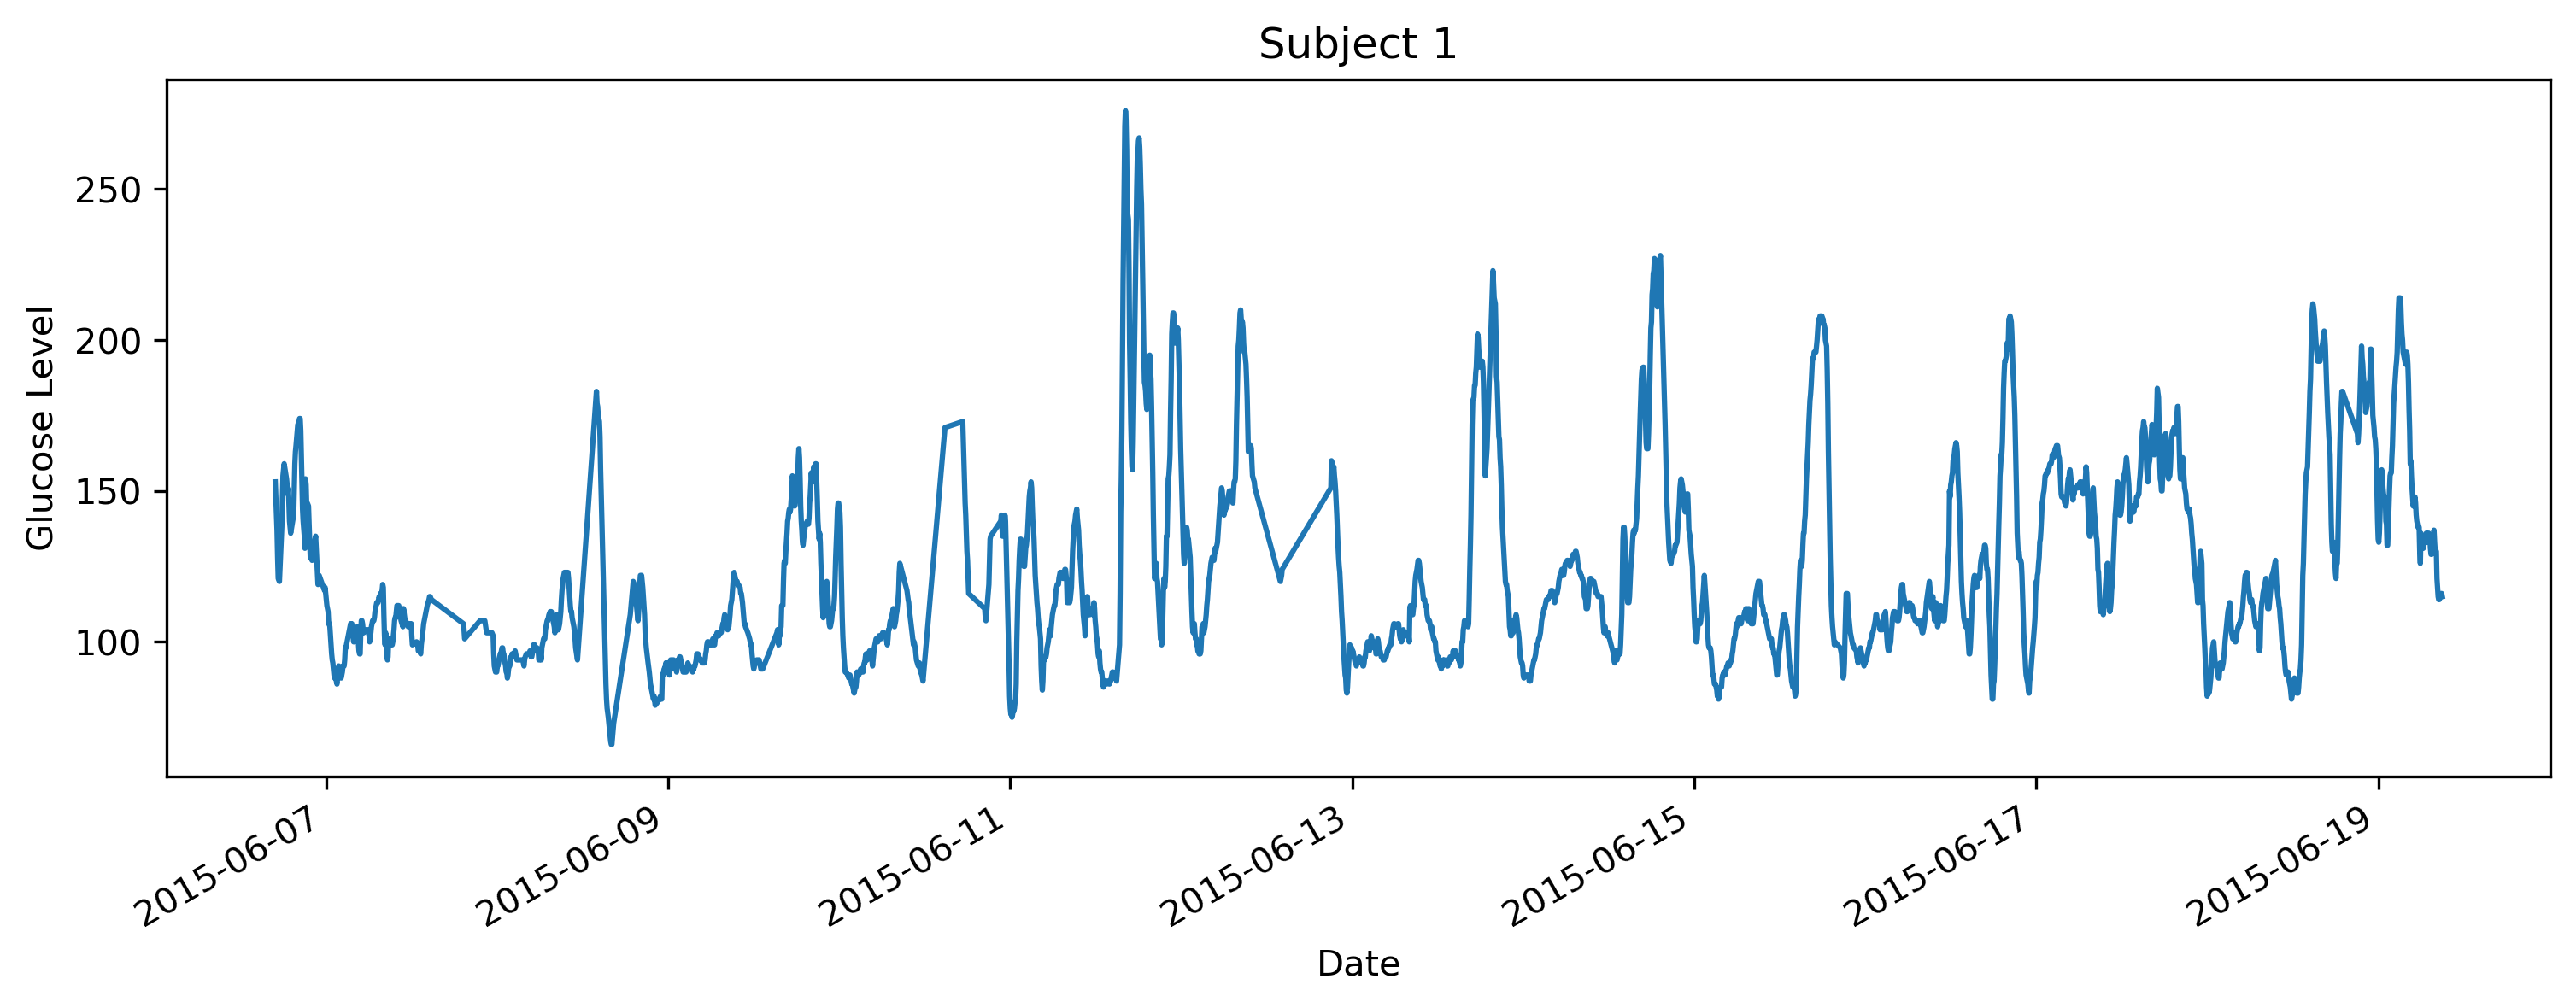

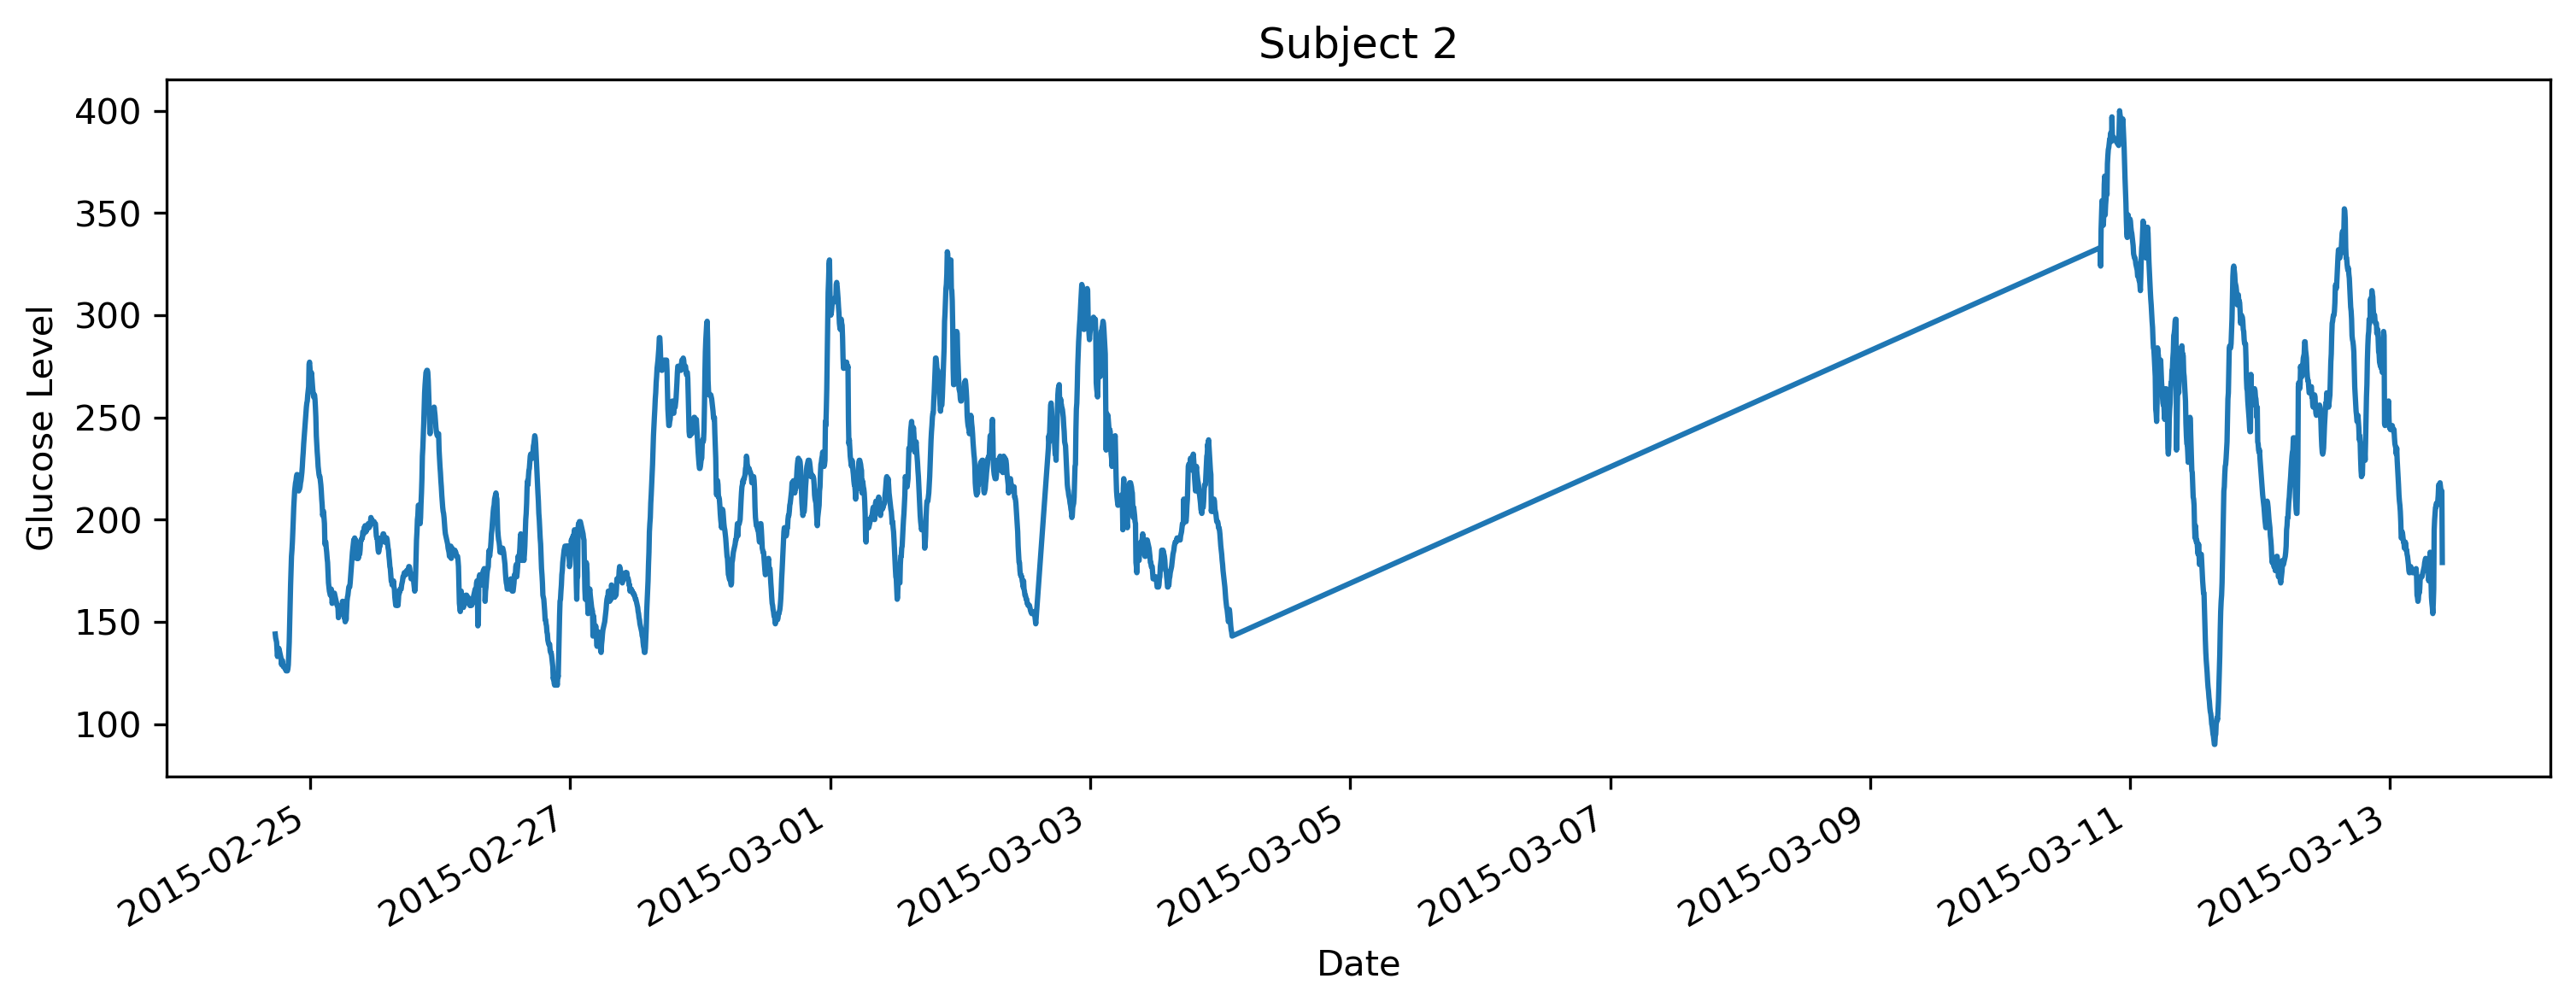

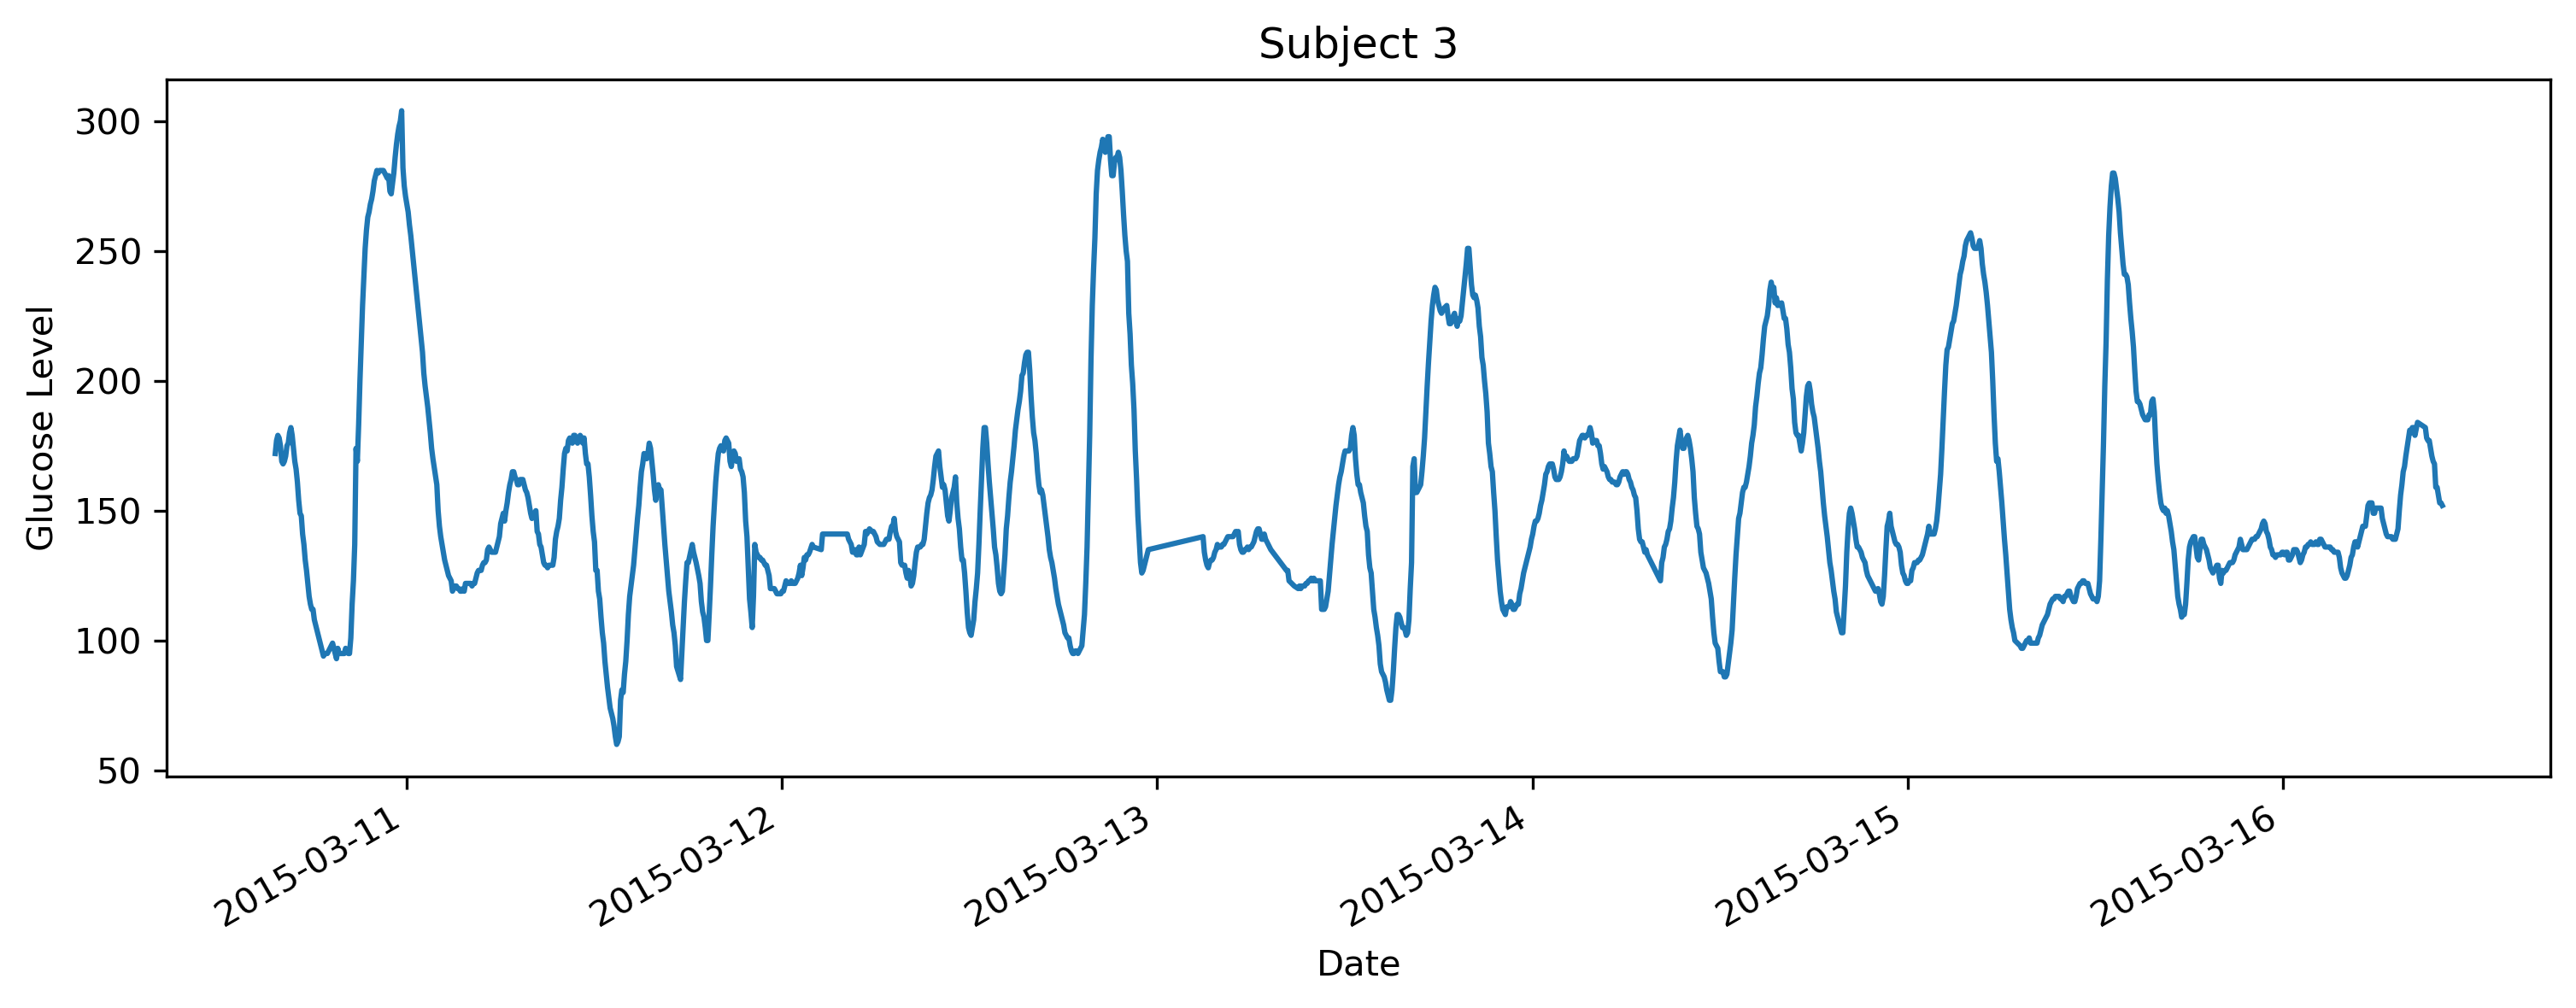

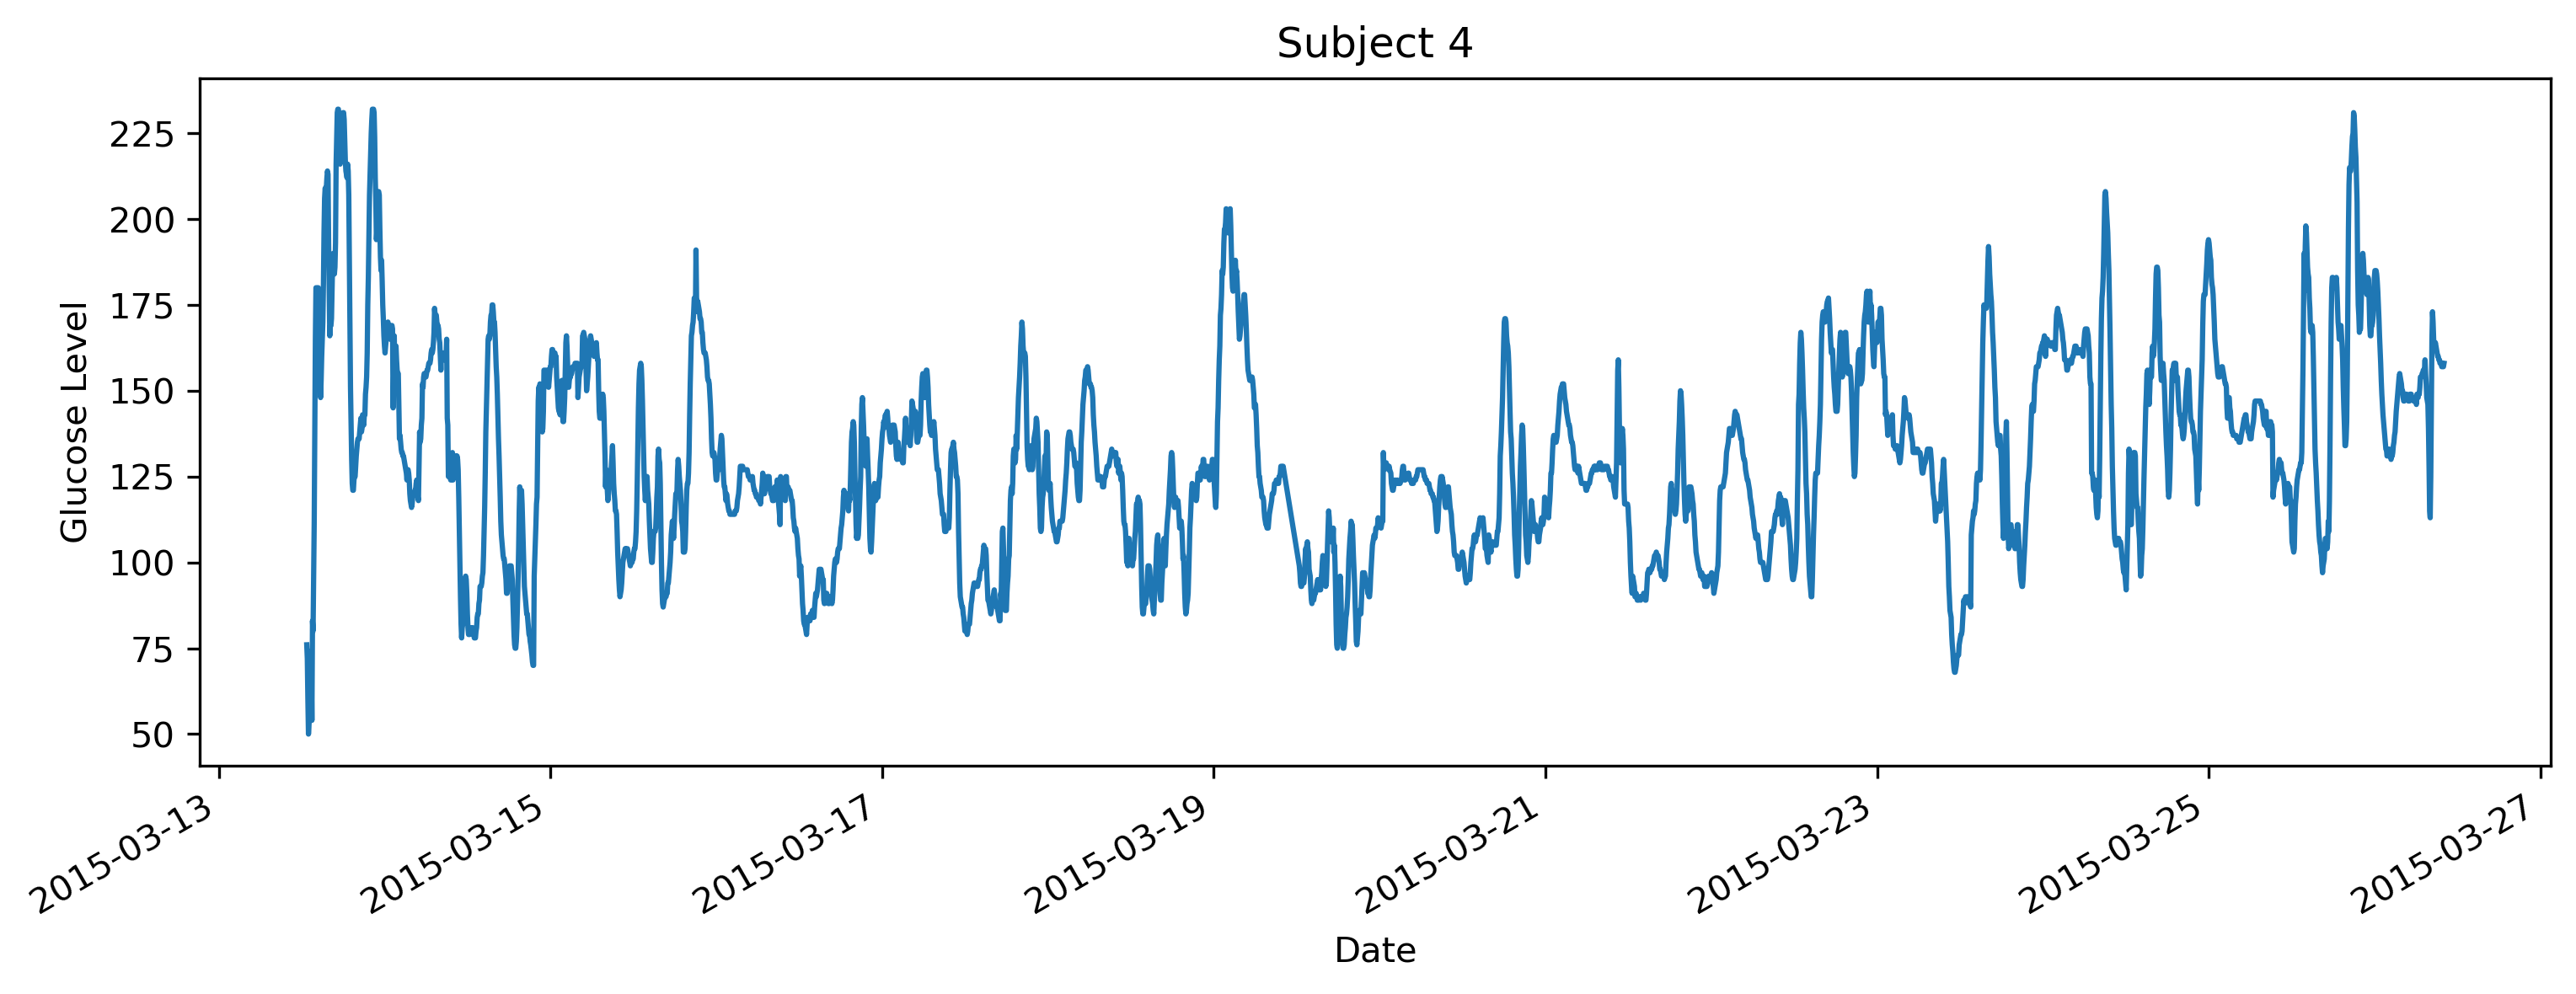

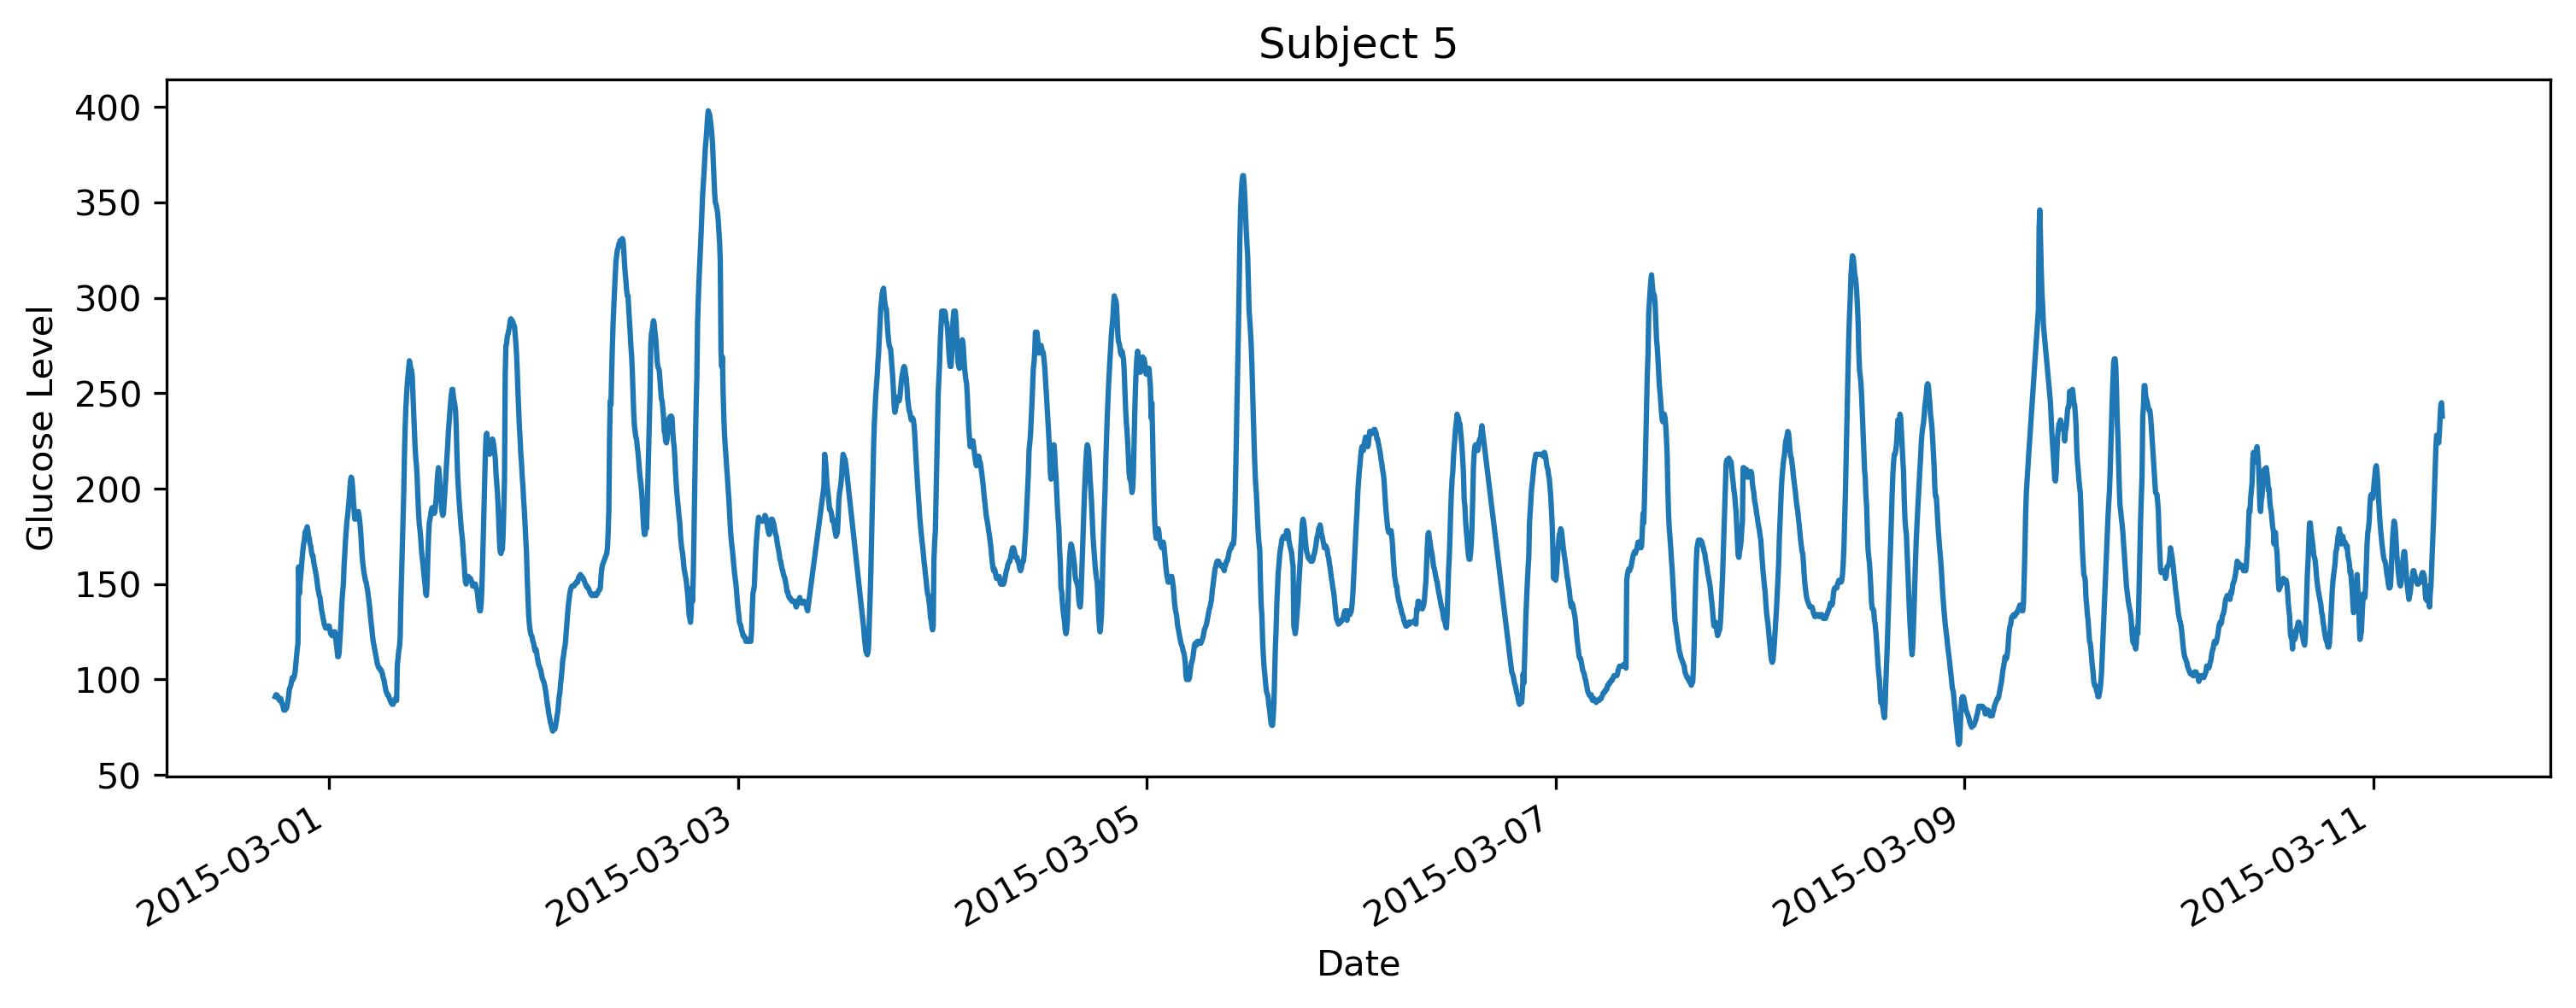

In [6]:
# Plot Subjects as line graphs
for subject in subjects:
    x = subj_data[subject].time # Time for x-axis
    y = subj_data[subject].gl # Glucose for y-axis

    fig, ax = plt.subplots(figsize = (12,4), dpi = 300)
    ax.plot(x, y)
    plt.title(subject)
    plt.xlabel("Date")
    plt.ylabel("Glucose Level")
    
    fig.autofmt_xdate() # slant x-axis
    plt.show()

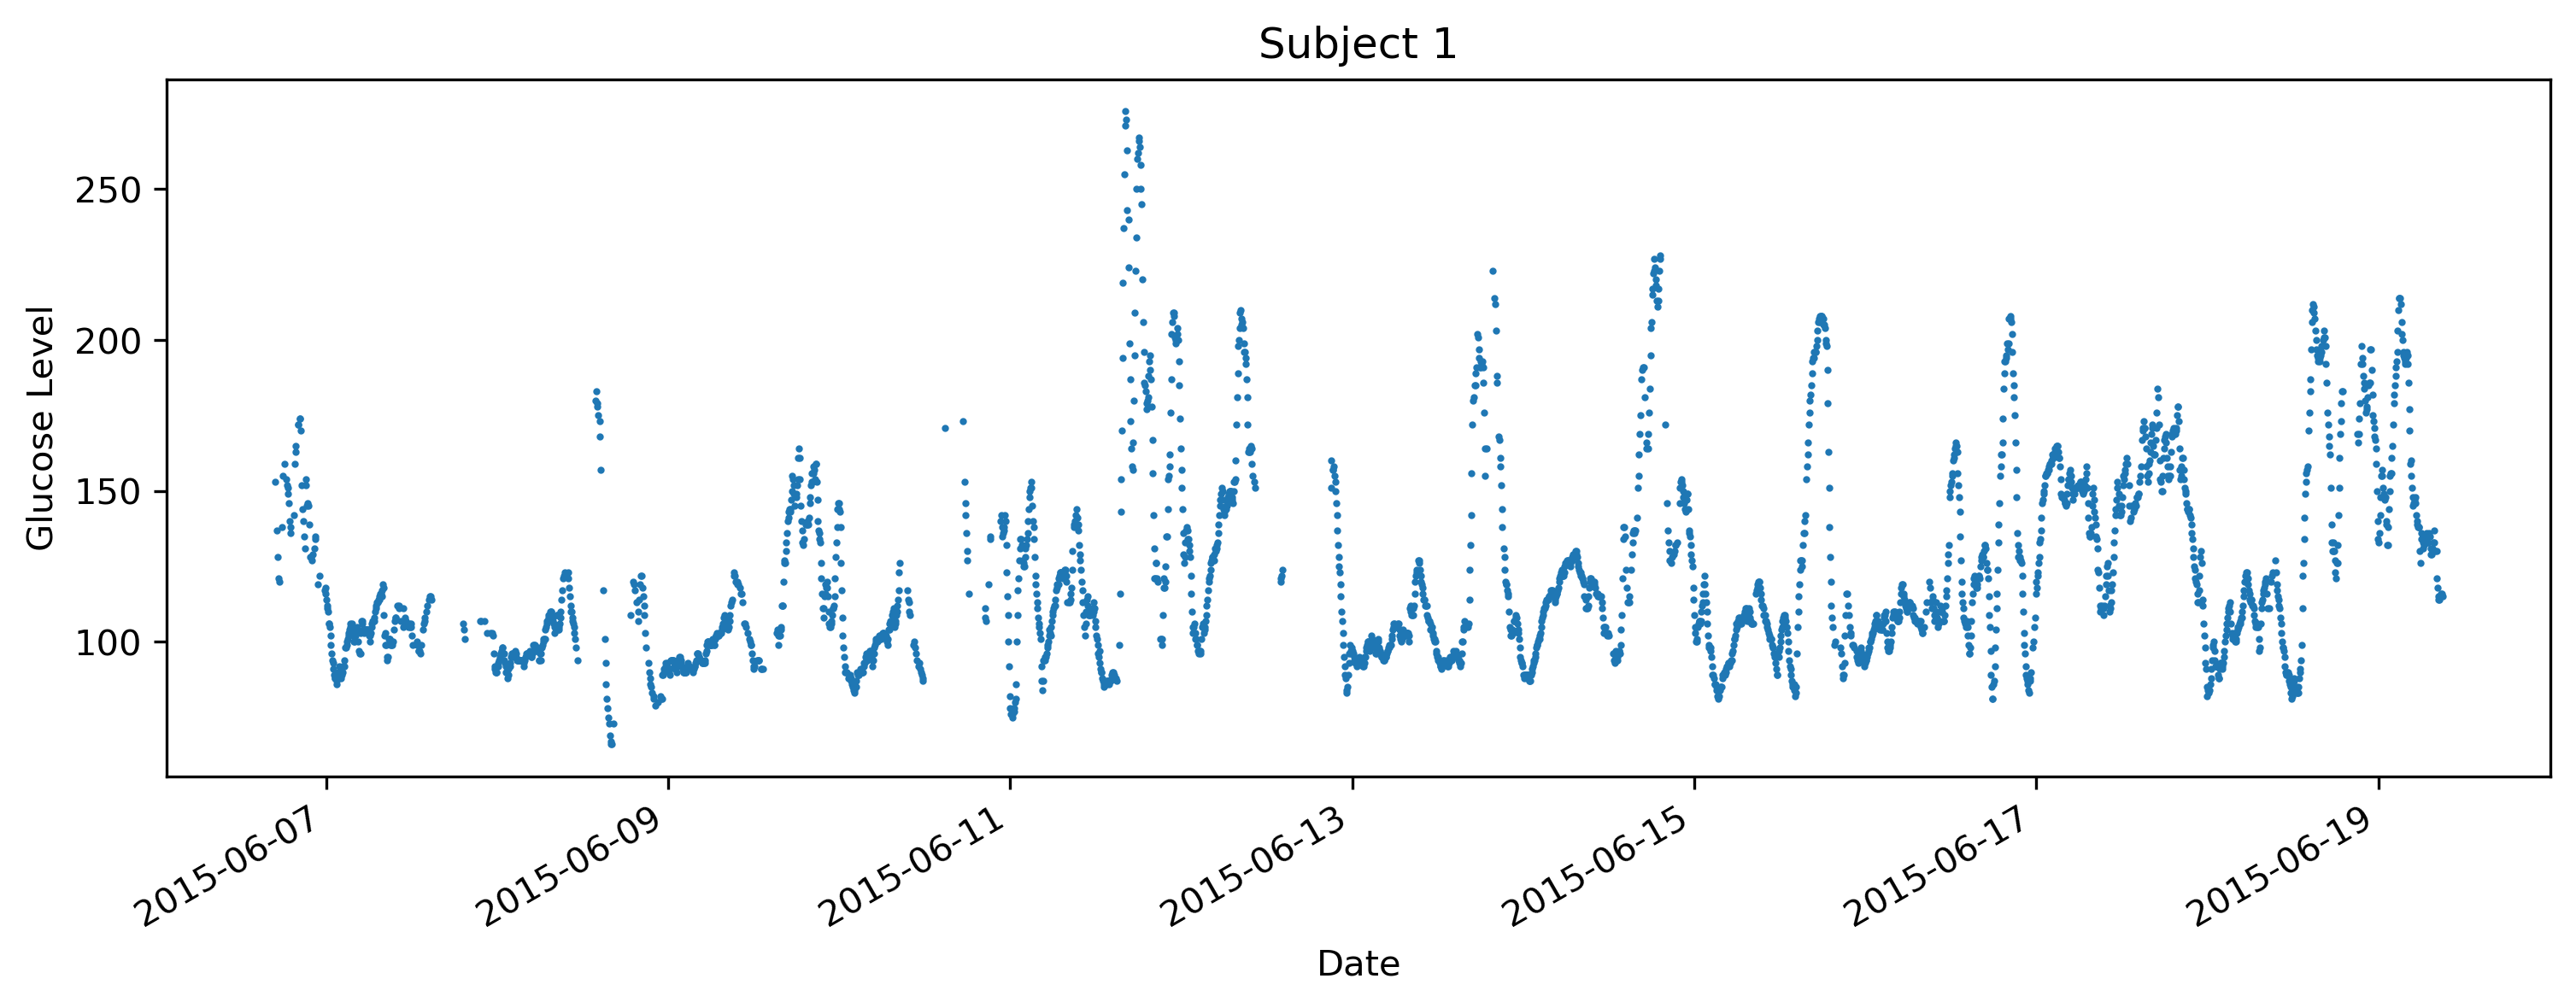

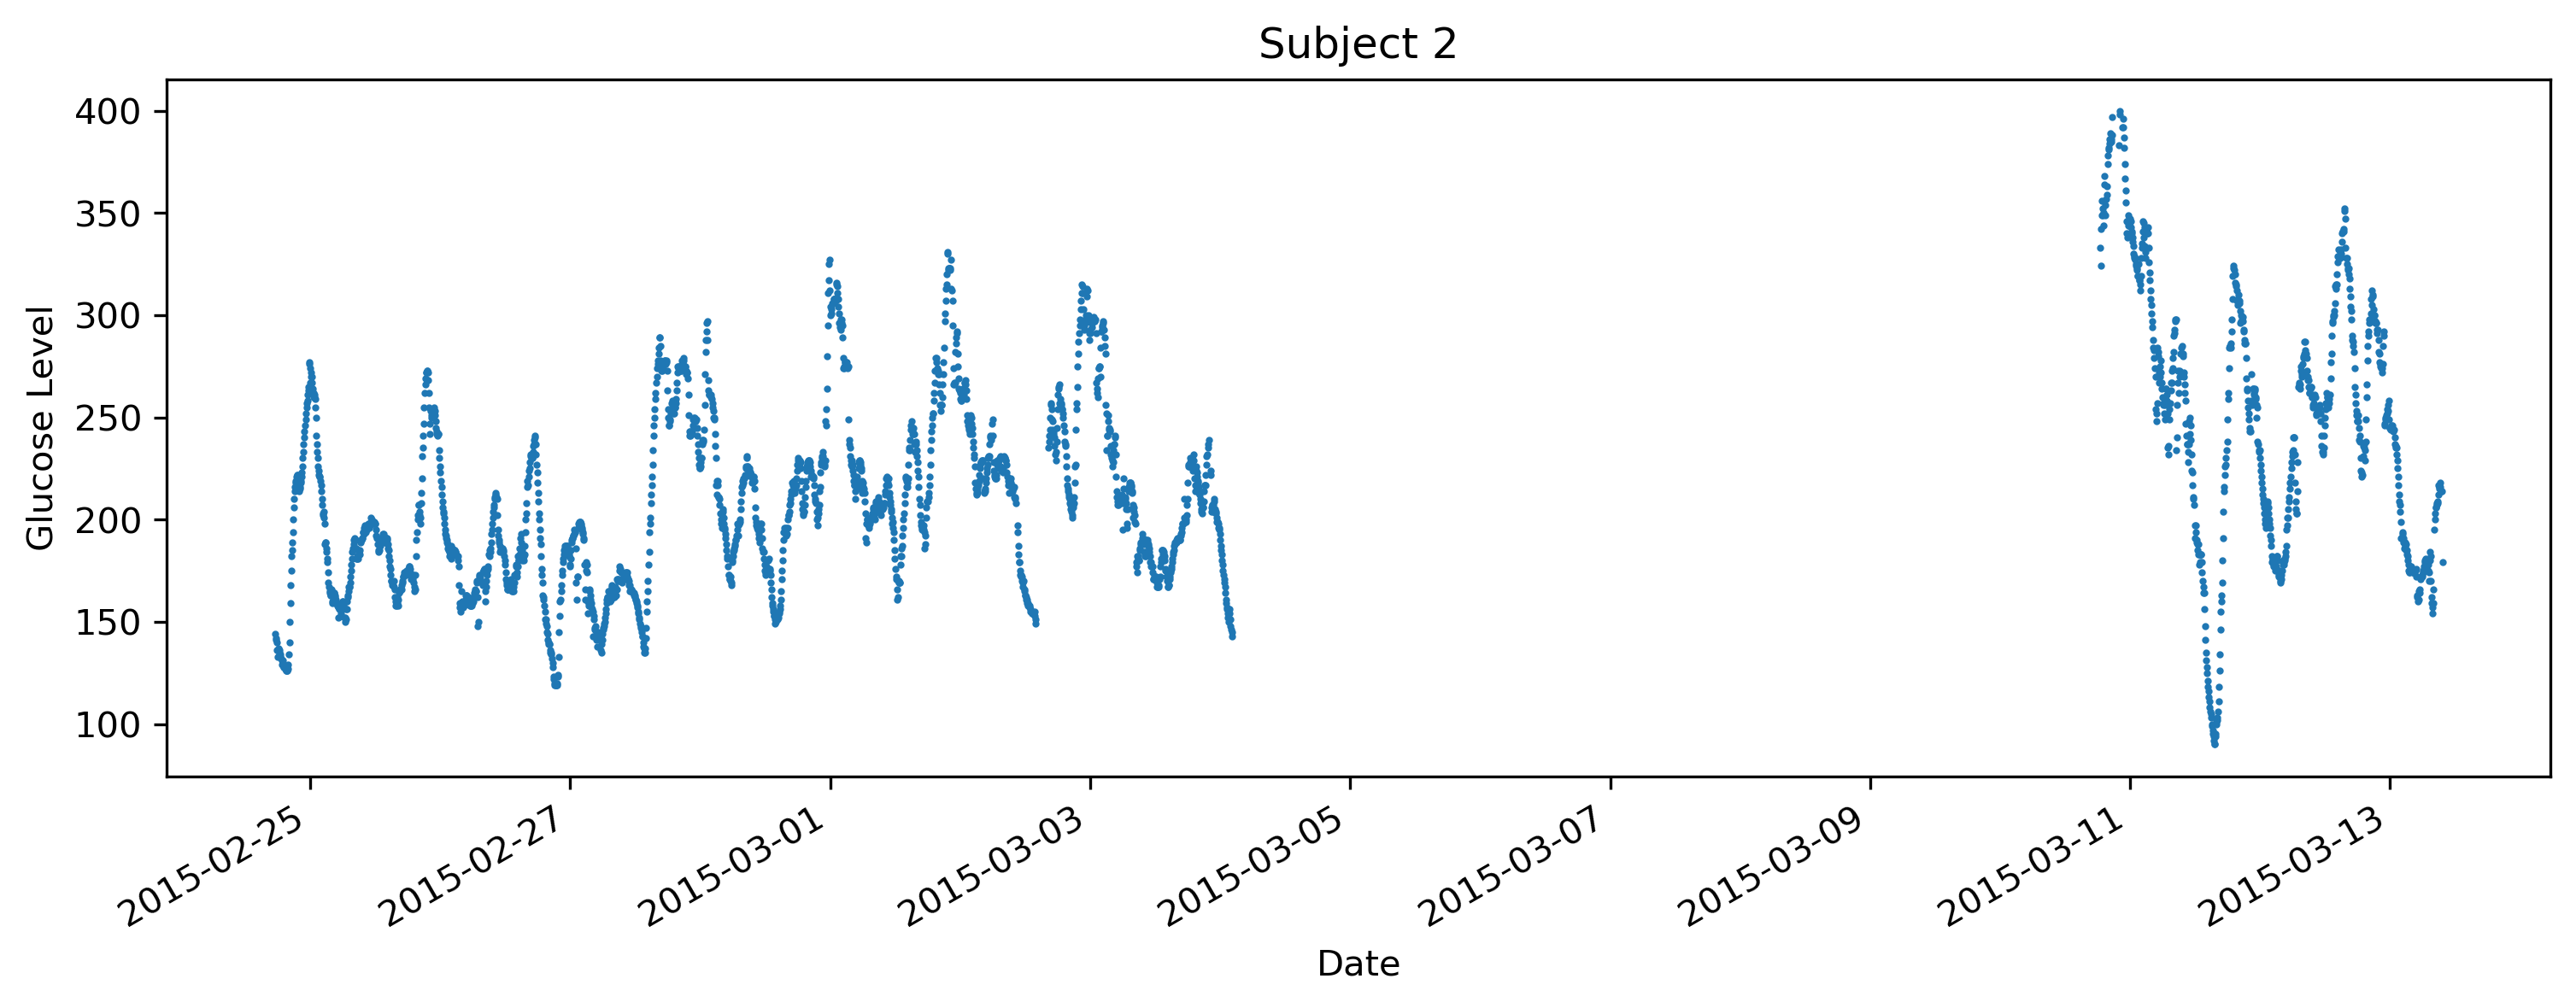

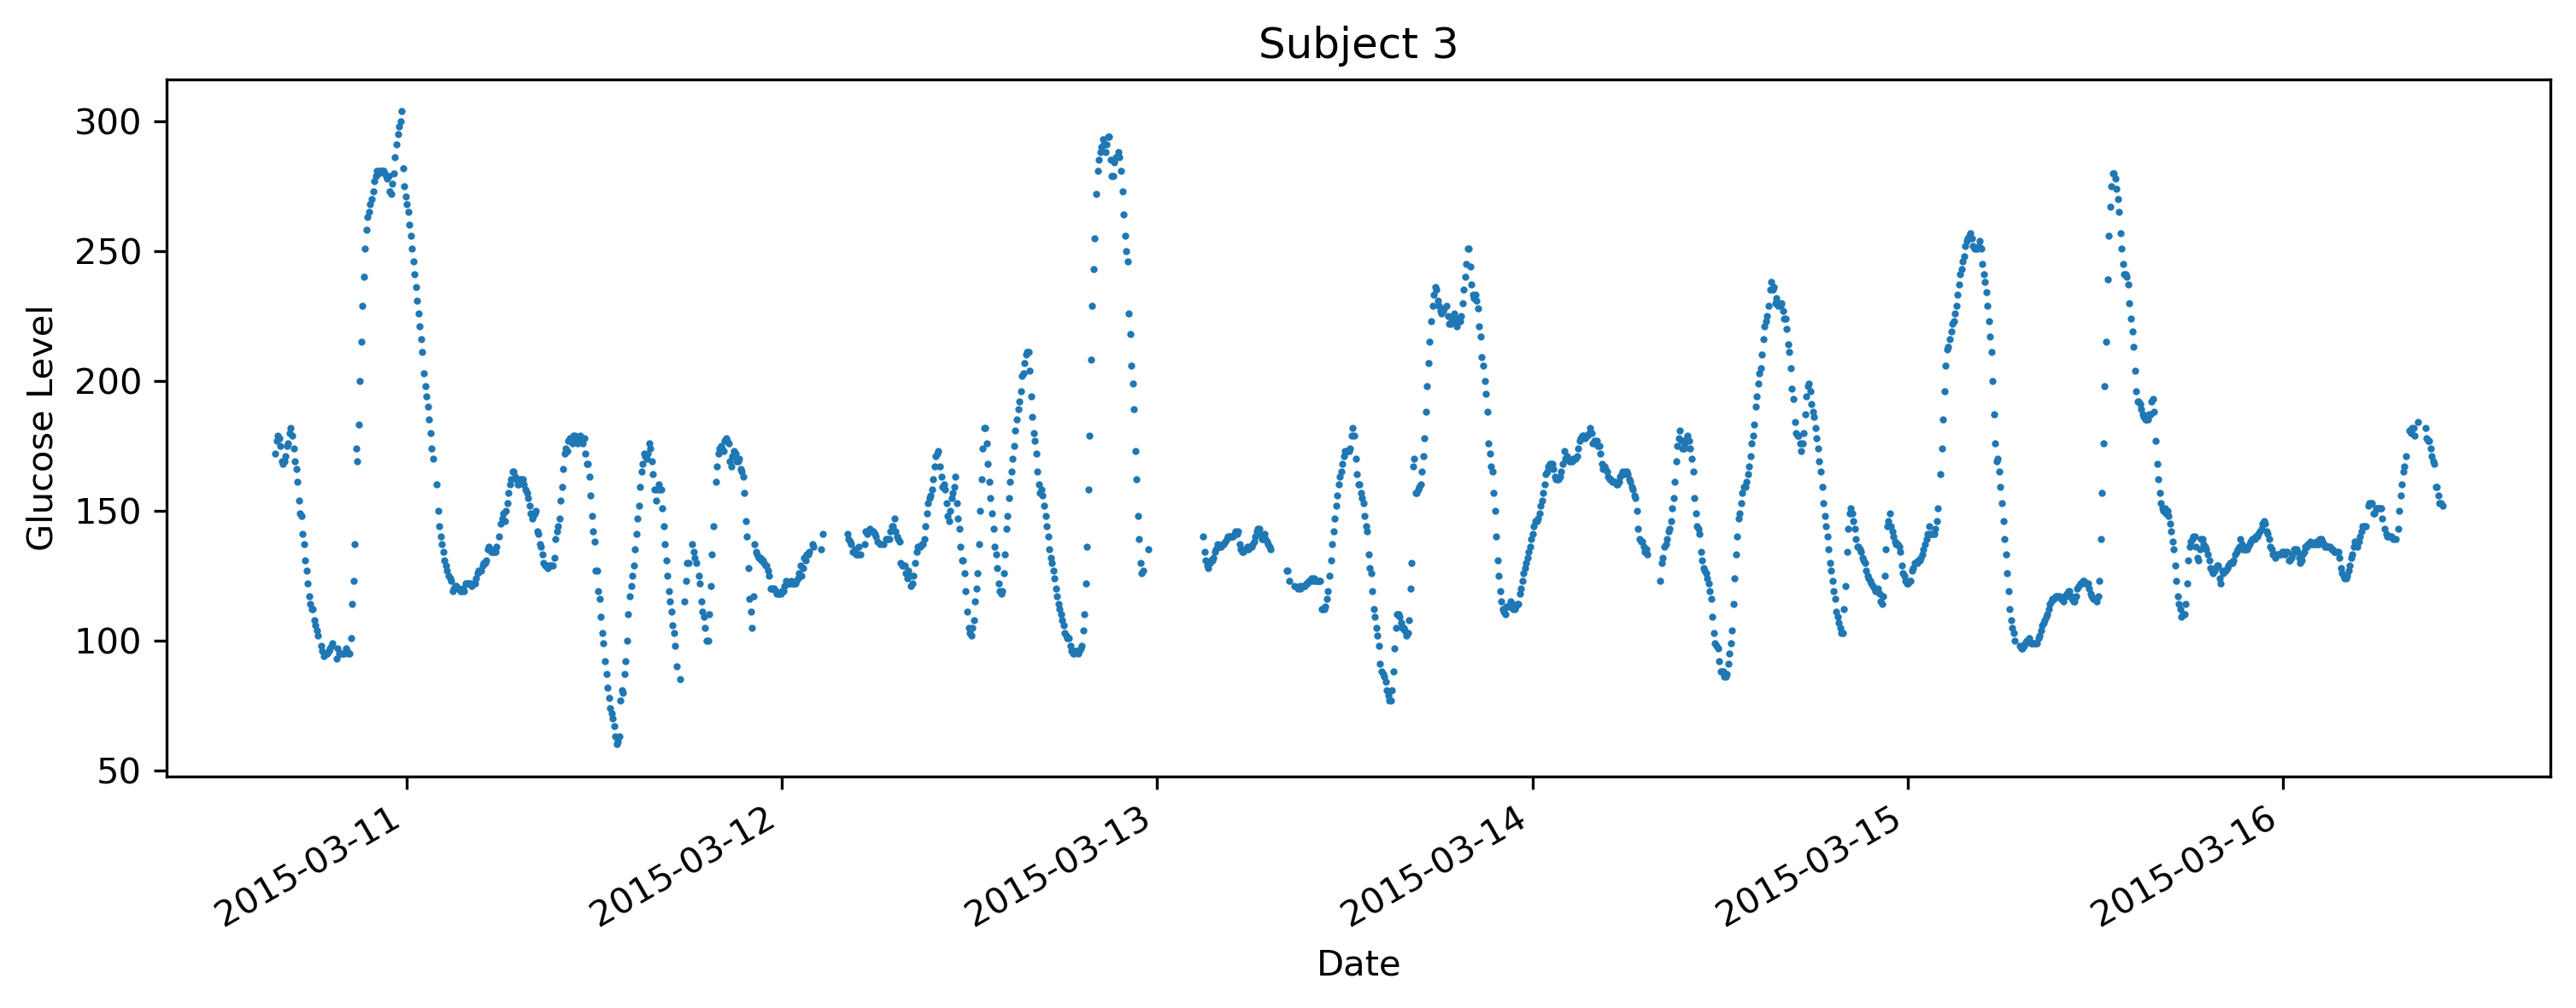

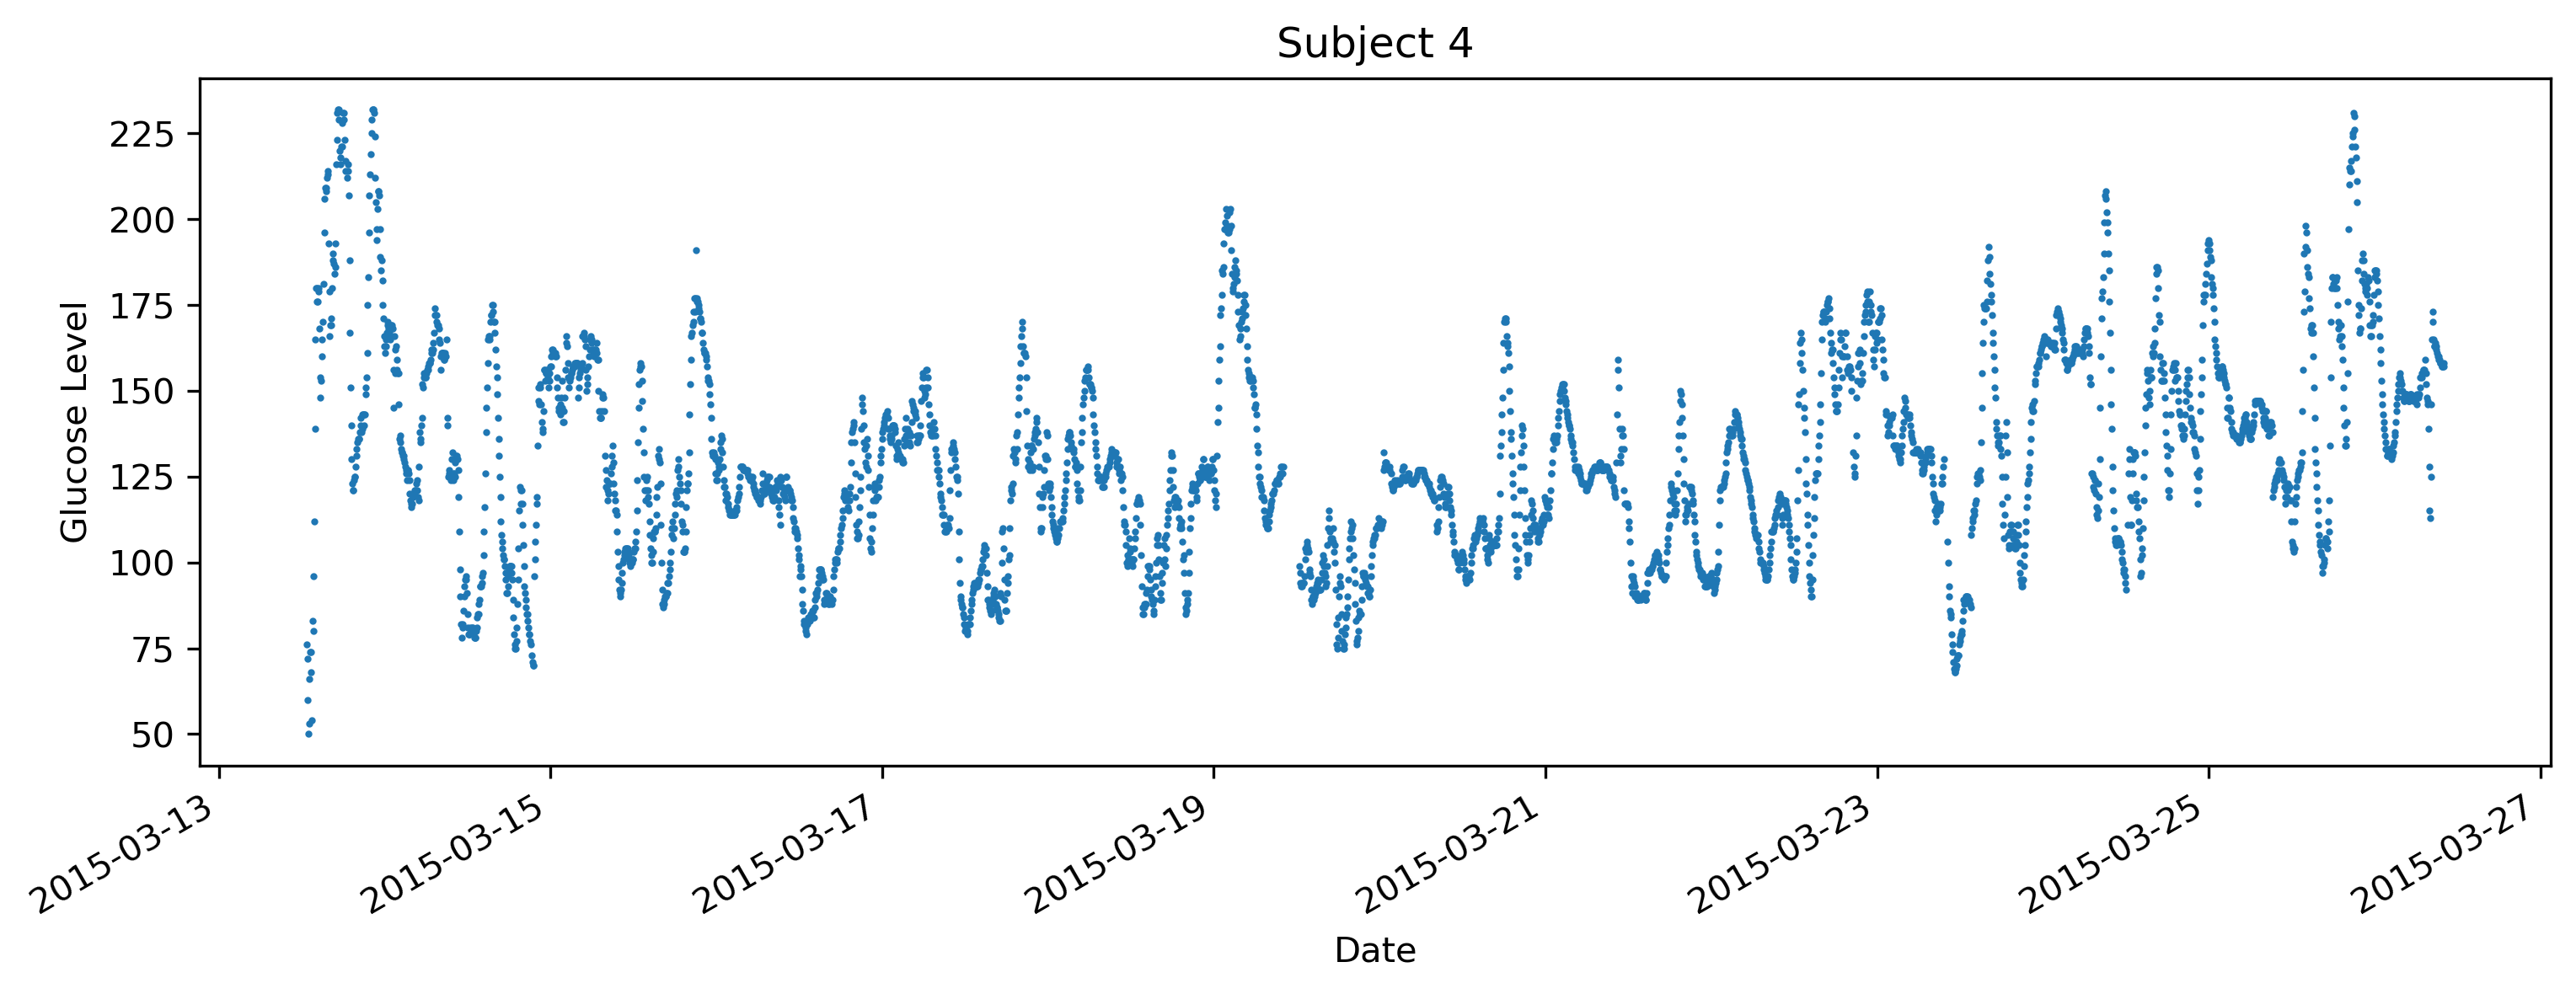

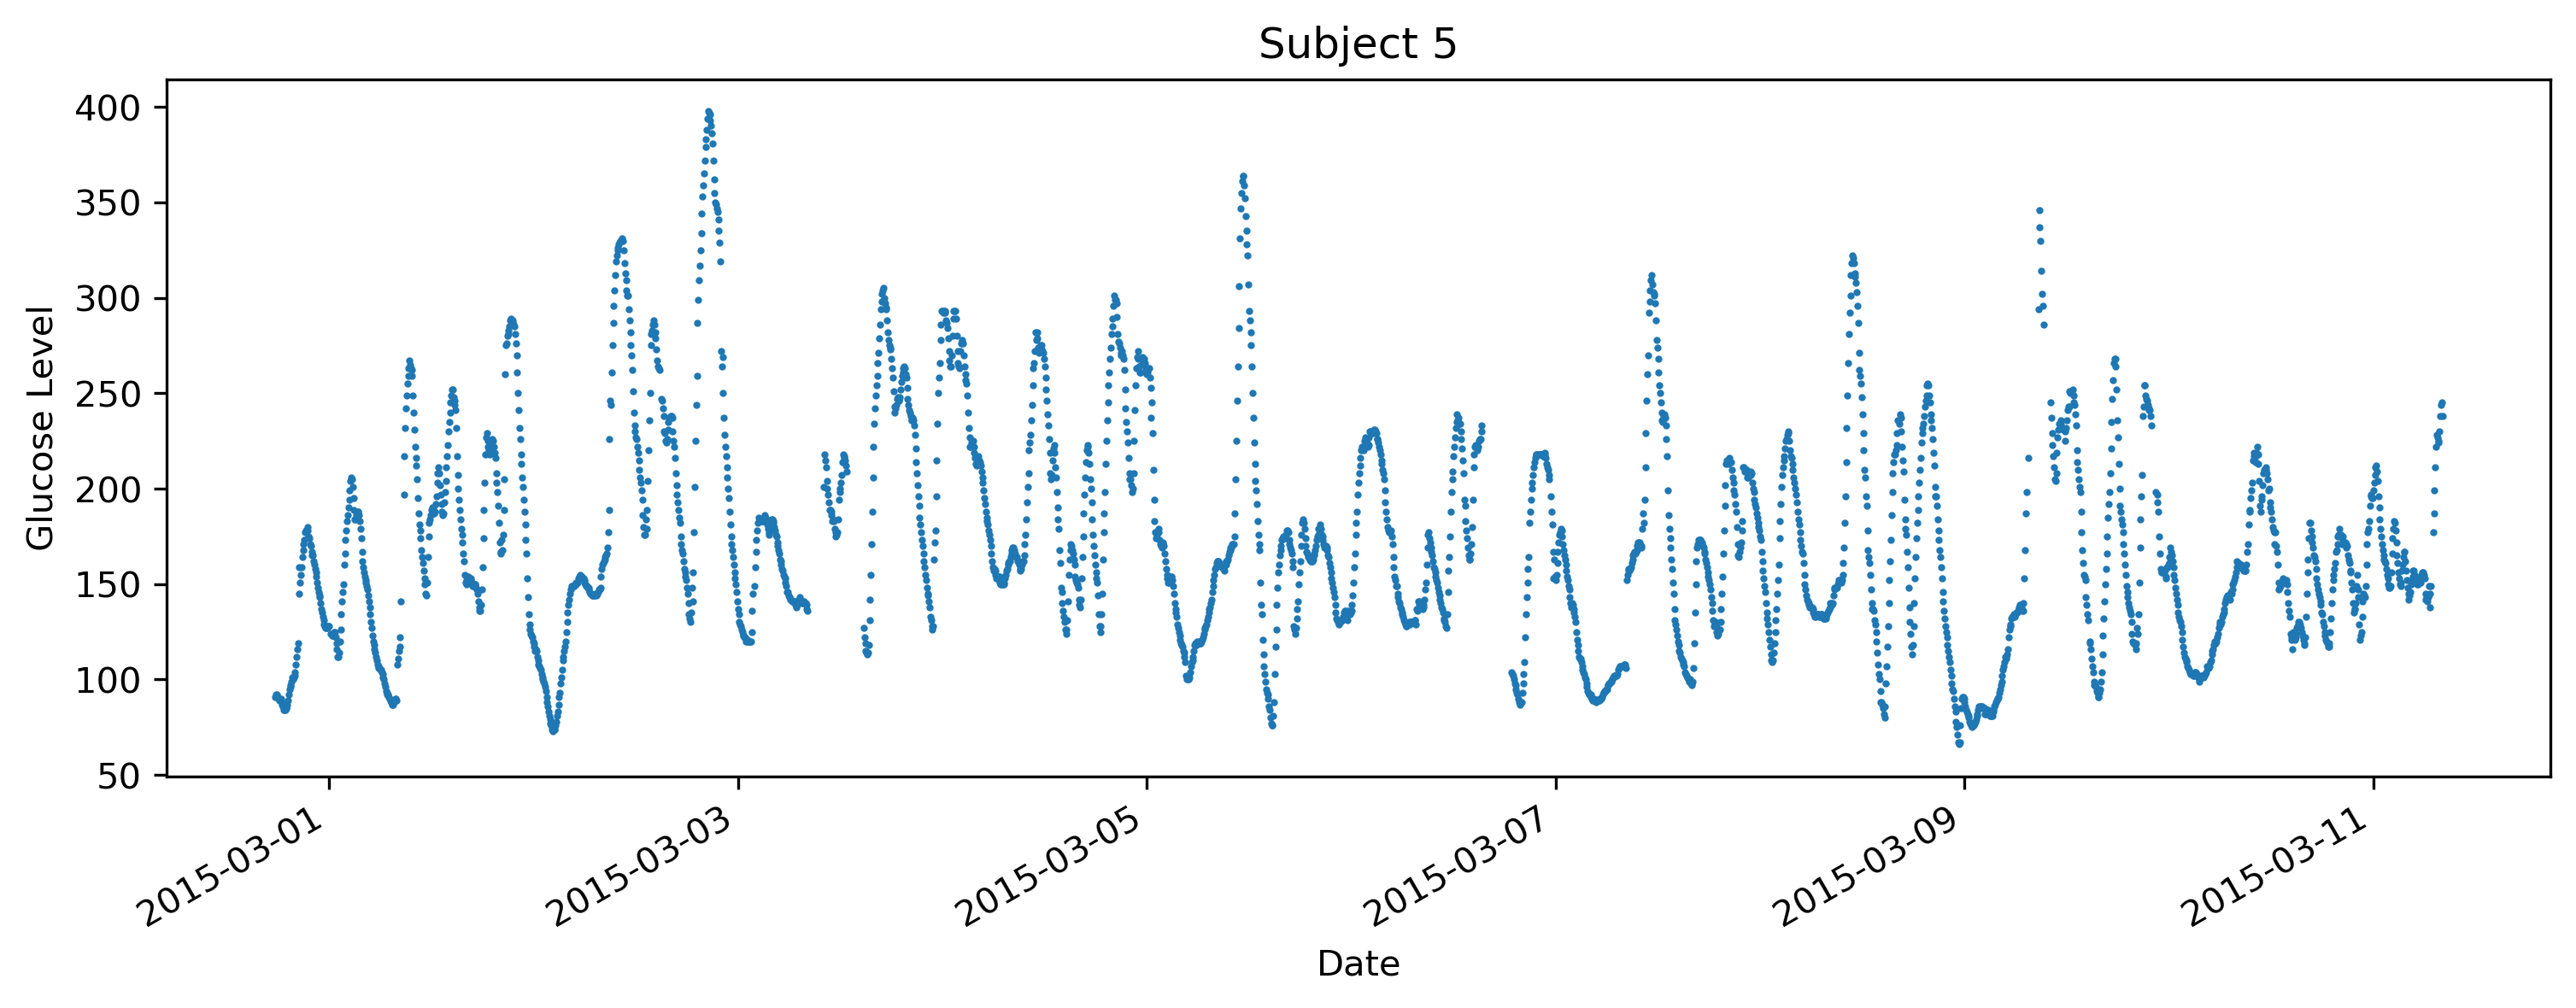

In [7]:
# Plot Subjects as dots
for subject in subjects:
    x = subj_data[subject].time # Time for x-axis
    y = subj_data[subject].gl # Glucose for y-axis

    fig, ax = plt.subplots(figsize = (12,4), dpi = 300)
    ax.plot_date(x, y, markersize = 1)
    plt.title(subject)
    plt.xlabel("Date")
    plt.ylabel("Glucose Level")
    
    fig.autofmt_xdate() # slant x-axis
    plt.show()

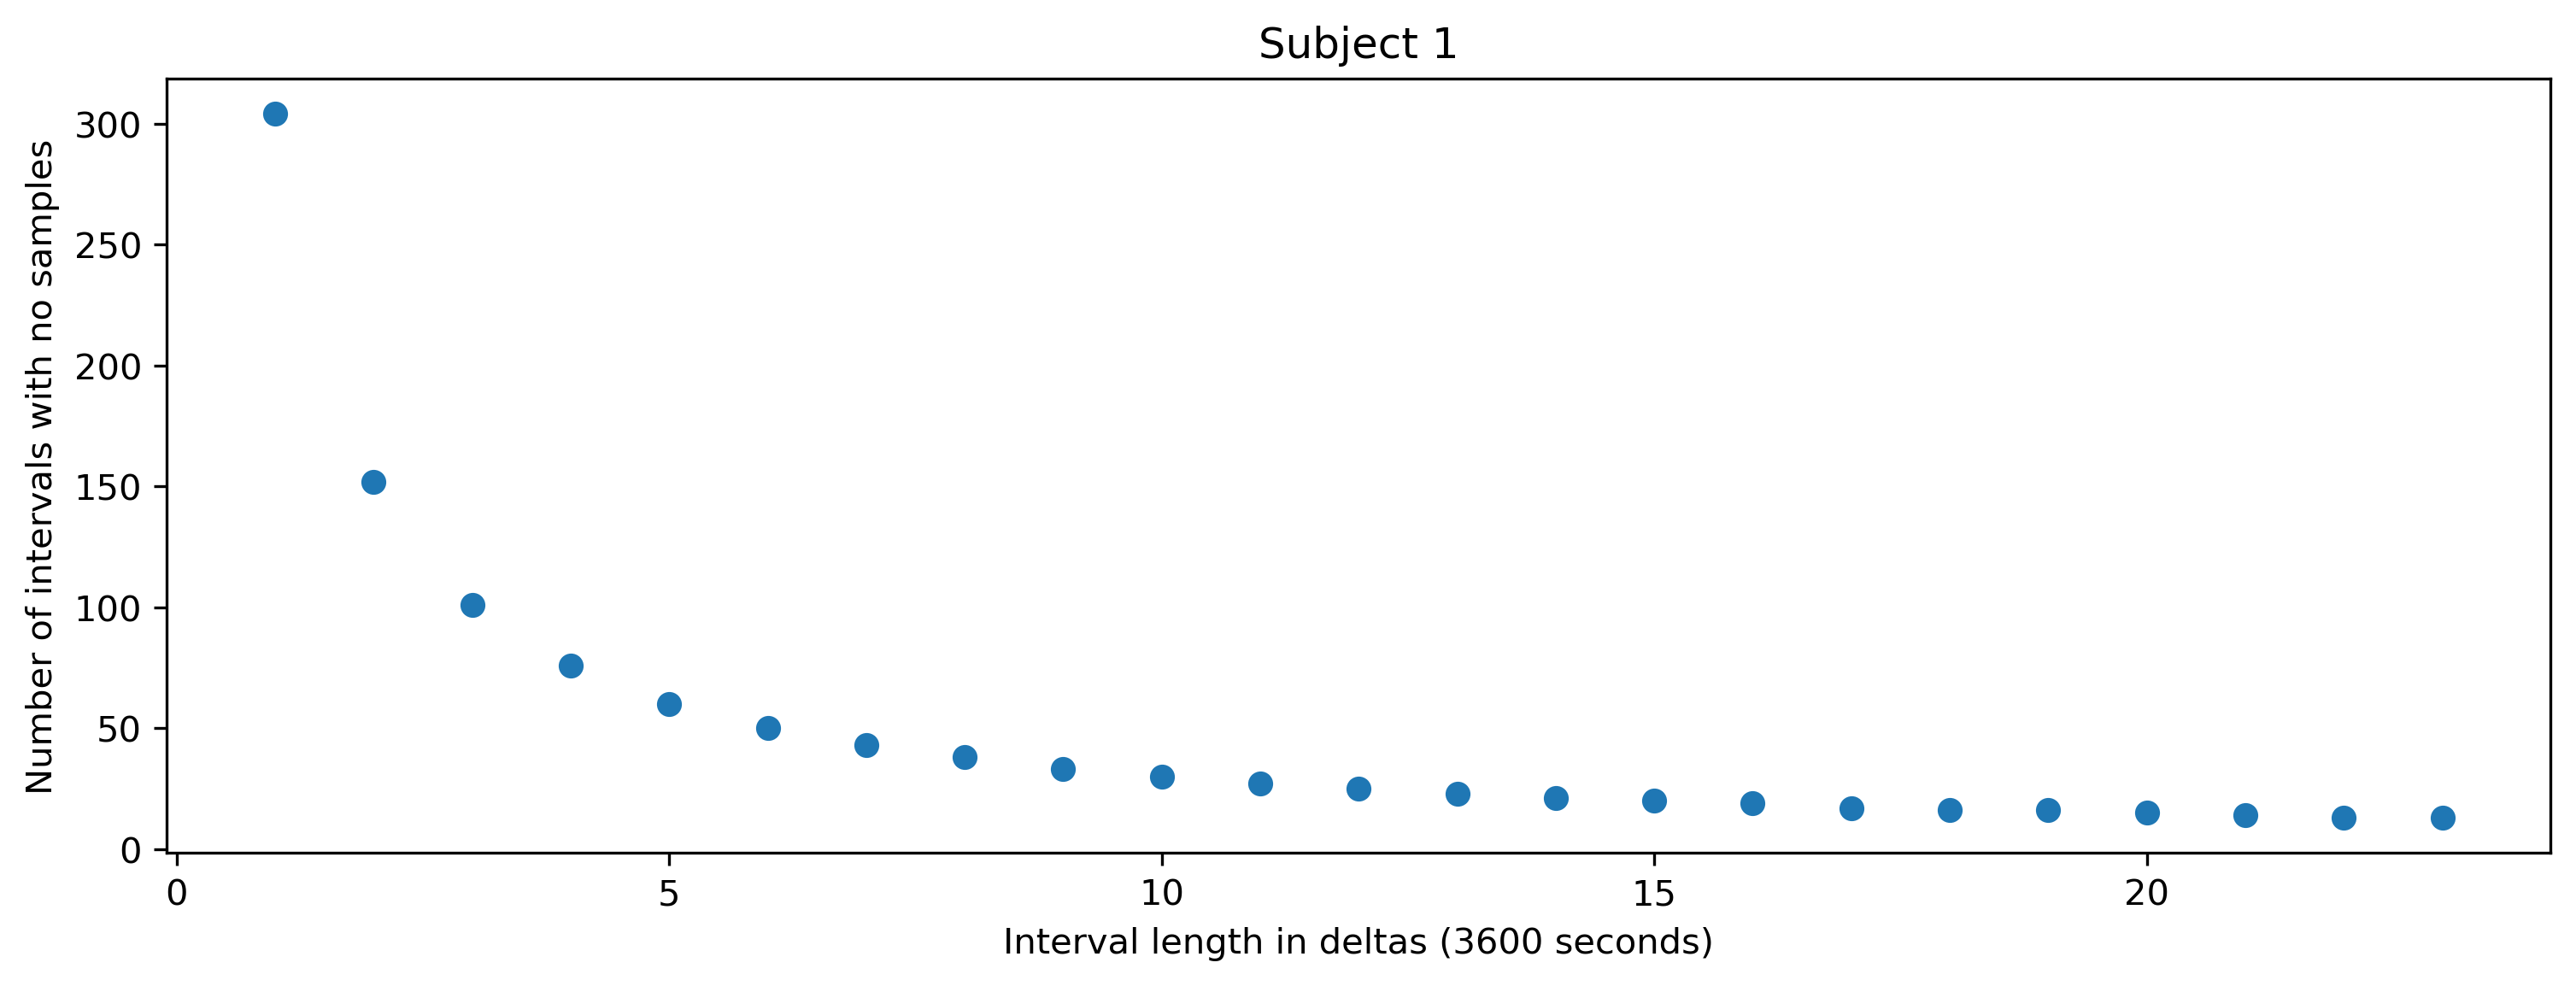

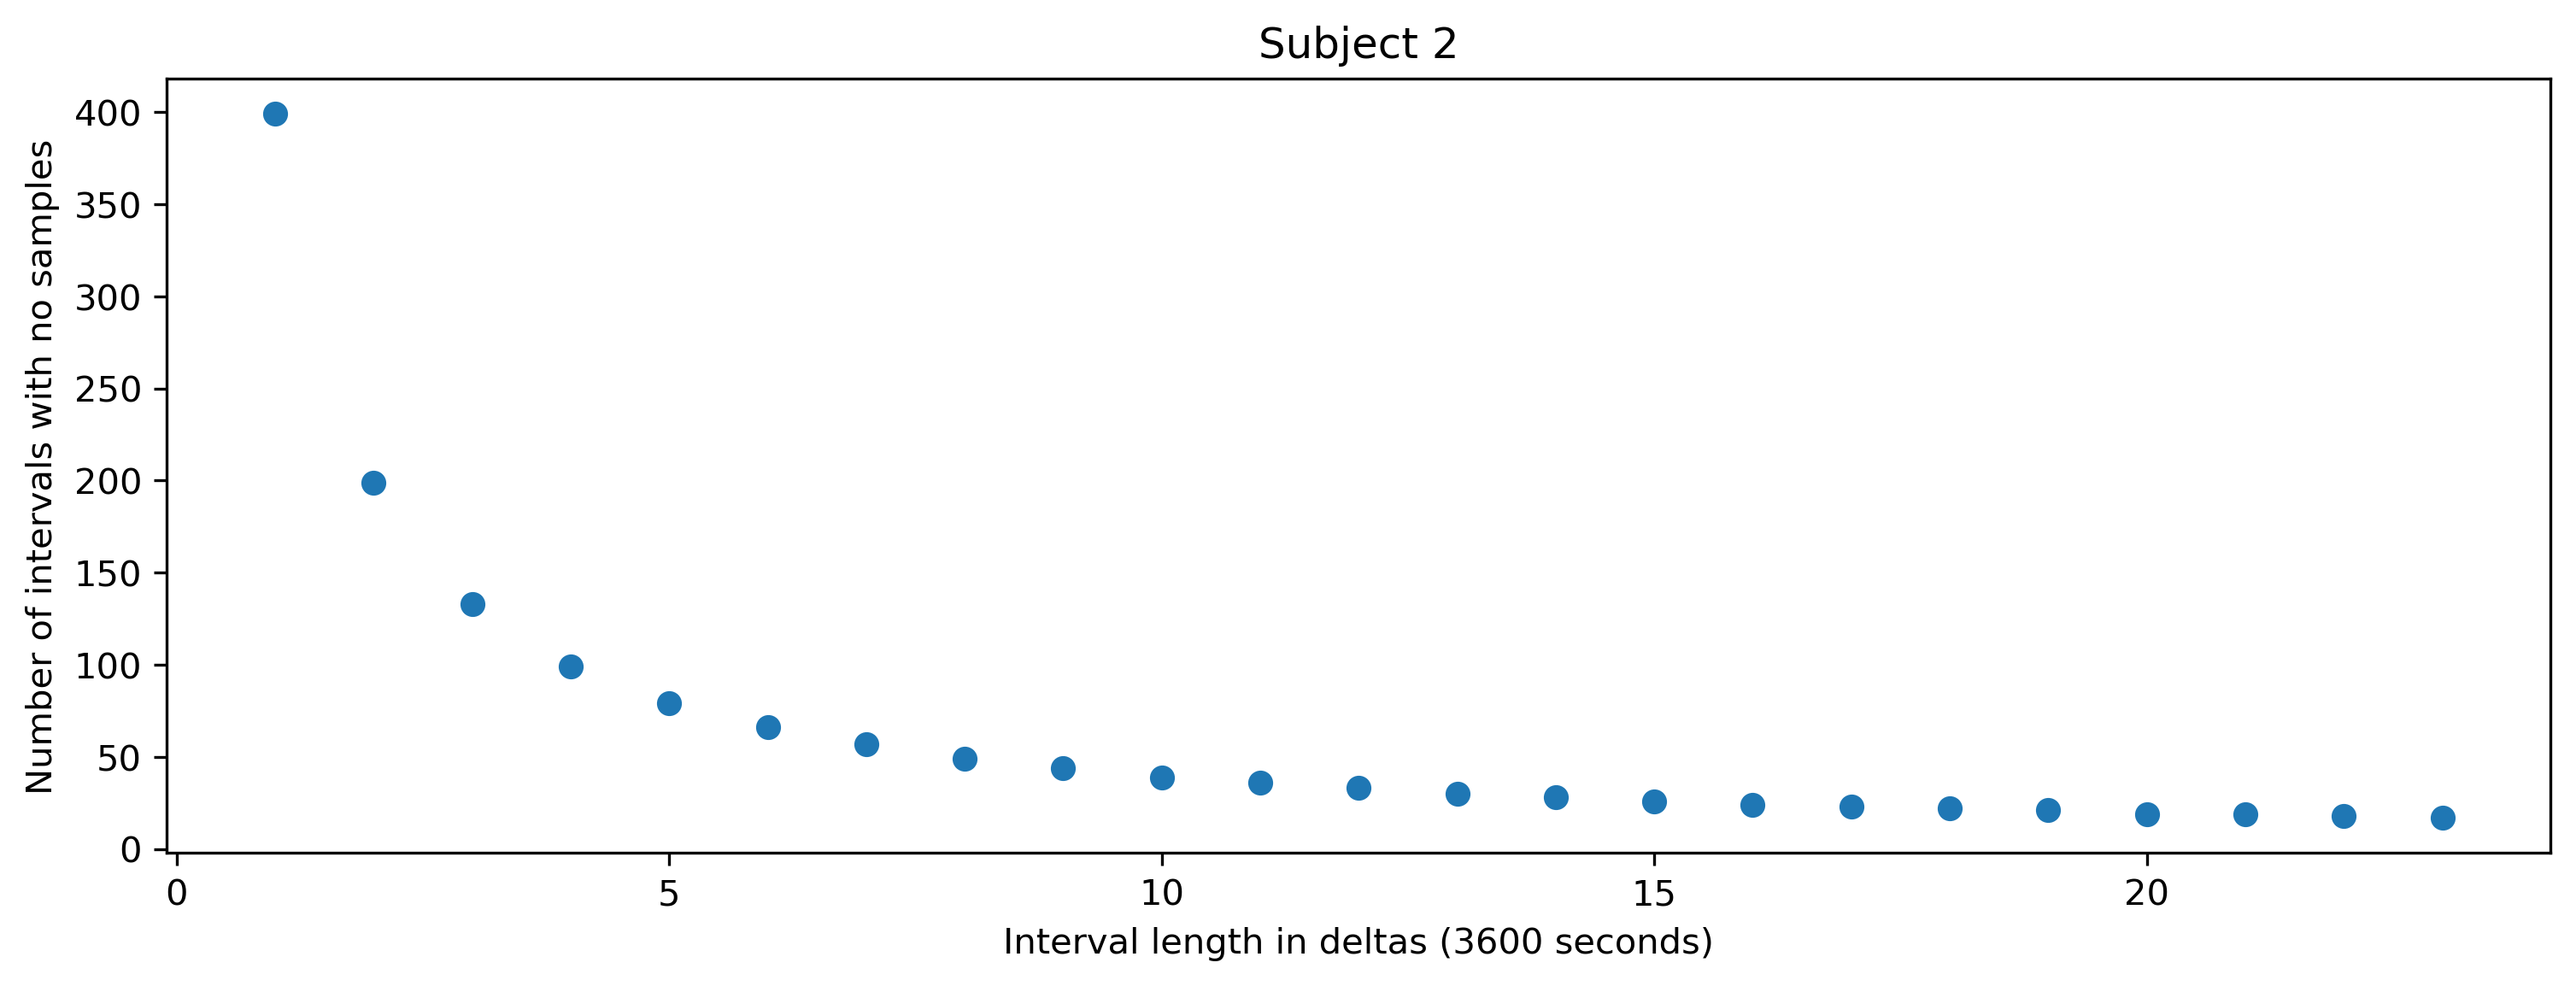

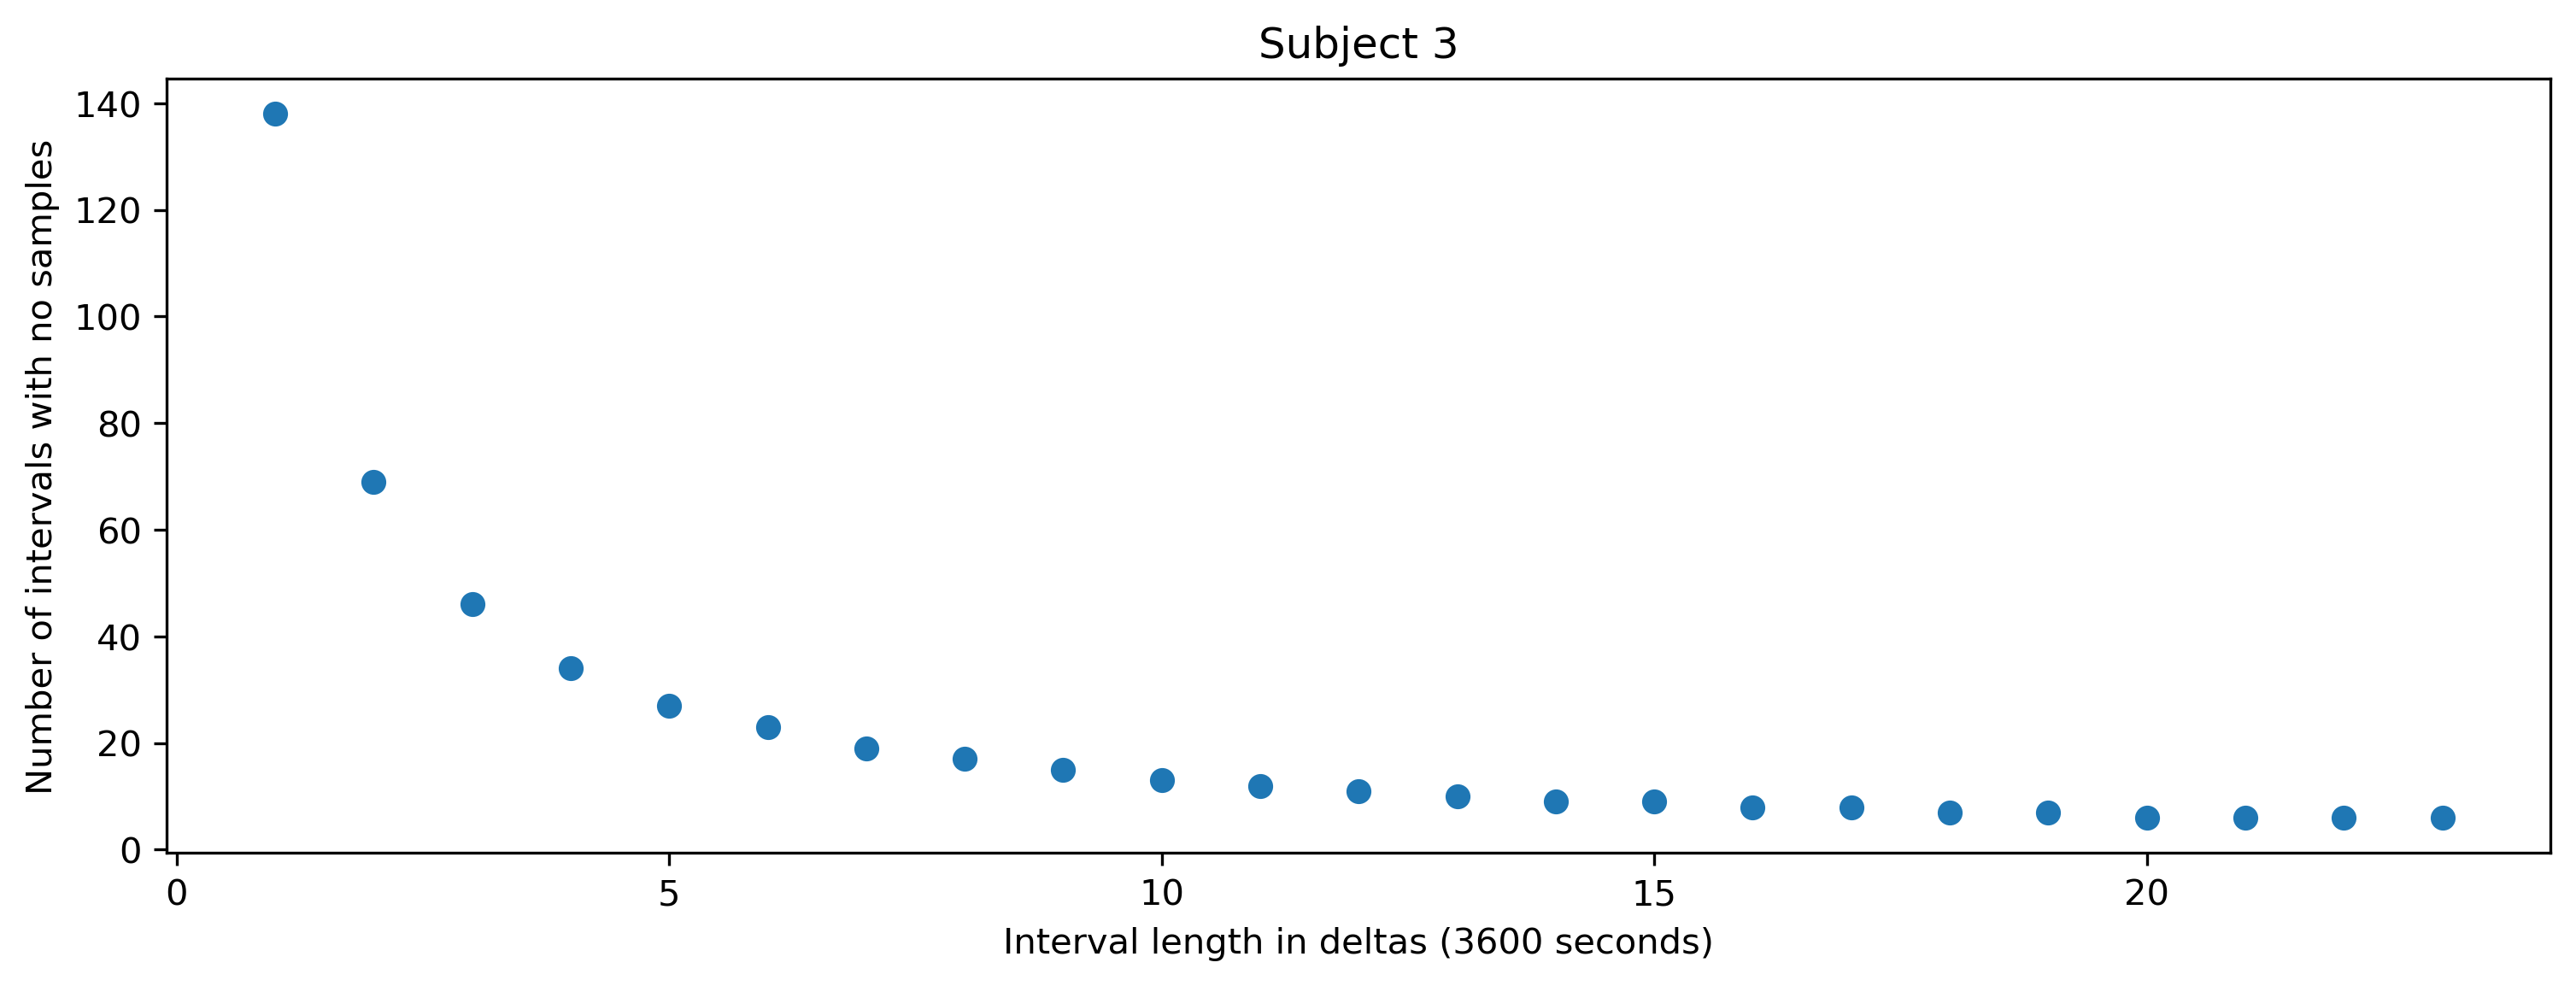

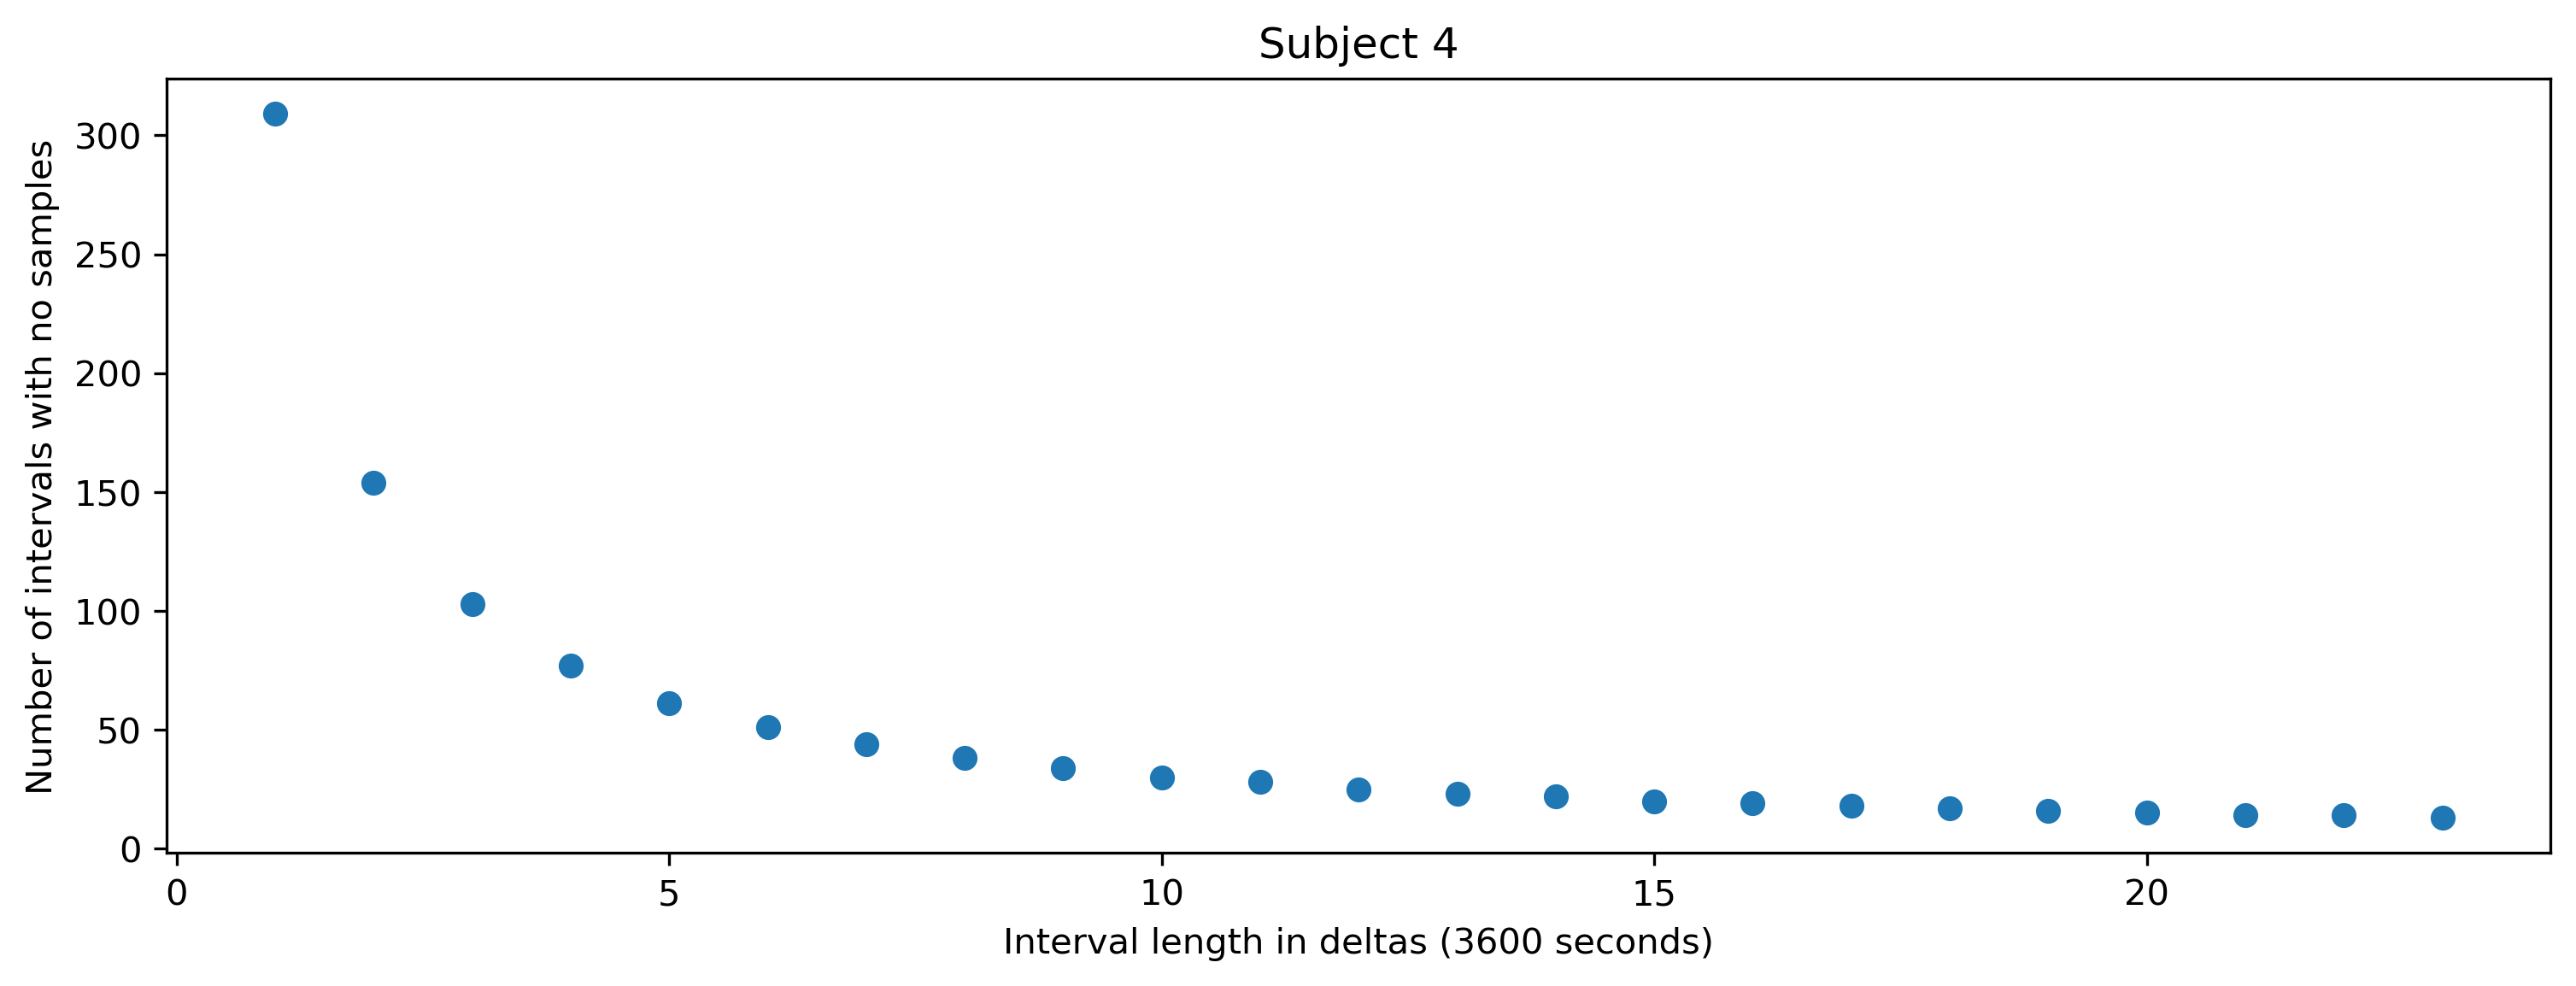

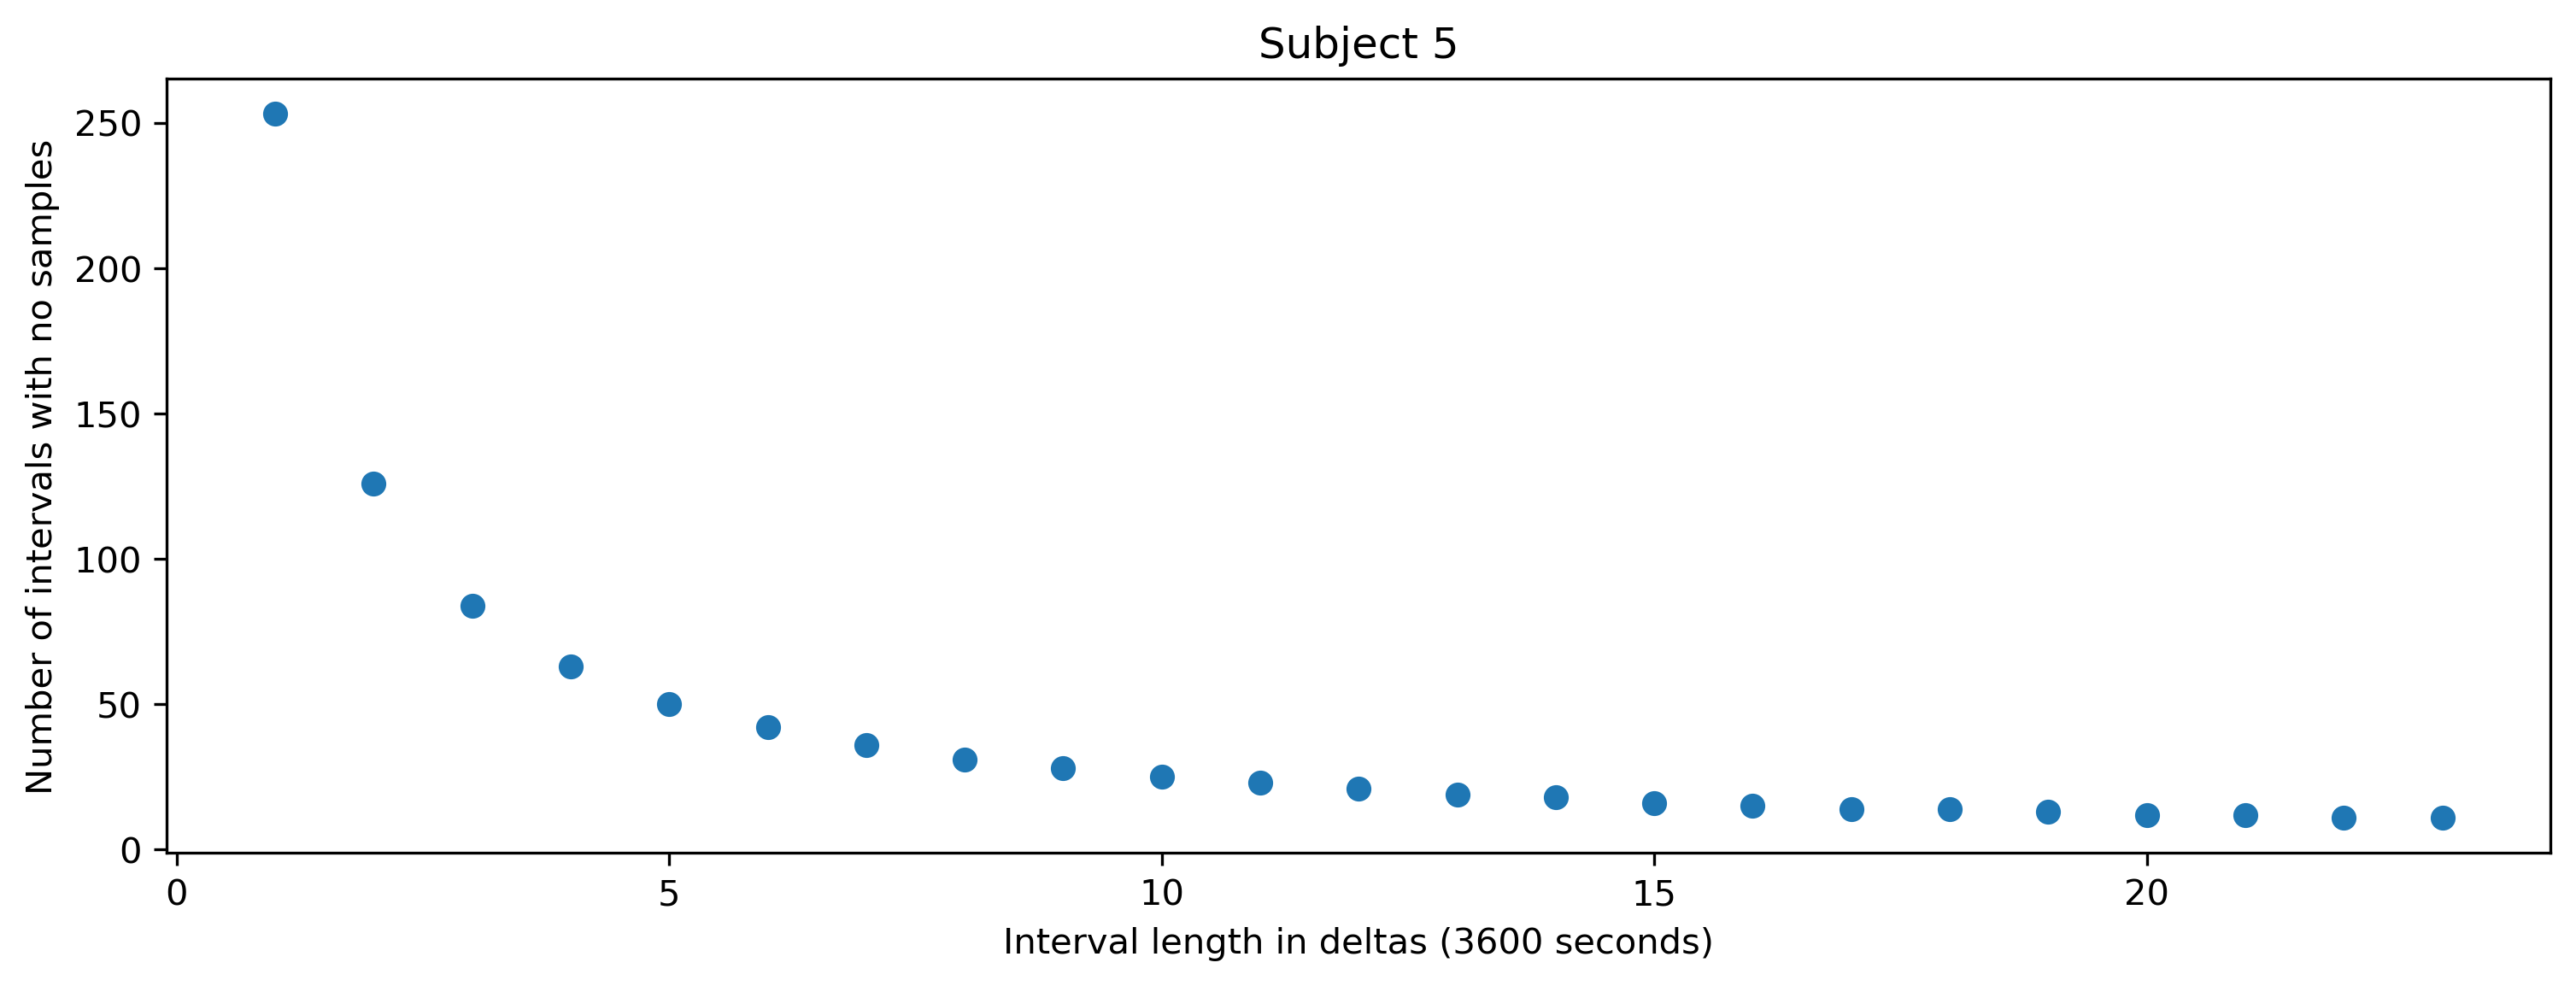

In [8]:
MINUTE = 60
HOUR = MINUTE * 60
def get_subject_graphs_for_time_segment_delta(delta, min_interval, max_interval):
    for subject in subjects:
        unix_time = [mktime(timestamp.timetuple()) for timestamp in subj_data[subject].time]
        no_sample_interval_count = []
        for i in range(1, max_interval // delta):
            cur_delta = i * delta
            no_sample_ct = 0
            for j in range(1, int(unix_time[-1] - unix_time[0]) // cur_delta + 1):
                if len(list(filter(lambda x: x >= (j-1) * cur_delta and x <= j * cur_delta, unix_time))) == 0: # Count number of samples in this time interval
                    no_sample_ct += 1
            no_sample_interval_count.append(no_sample_ct)

        fig, ax = plt.subplots(figsize = (12,4), dpi = 300)
        ax.scatter(range(1, len(no_sample_interval_count) + 1), no_sample_interval_count)
        plt.title(subject)
        plt.xlabel(f"Interval length in deltas ({delta} seconds)")
        plt.ylabel("Number of intervals with no samples")
        plt.show()

min_interval, max_interval = 0, HOUR * 24
delta = 1 * HOUR
get_subject_graphs_for_time_segment_delta(delta, min_interval, max_interval)

In [56]:
# Bucket time intervals  (5 minute intervals)
subj_td = {"Subject 1": [], "Subject 2": [], "Subject 3": [], "Subject 4": [], "Subject 5": []}

for subject in subjects:
    times = set()
    time_intervals = []
    data = subj_data[subject].time
    fmt = '%Y-%m-%d %H:%M:%S'
    for i in range(1, len(data)):
        t2 = datetime.strptime(str(data[i]), fmt)
        t1 = datetime.strptime(str(data[(i-1)]), fmt)
        td = float((t2 - t1).total_seconds() / 60)
        time_intervals.append(td)
        if td not in times:
            times.add(td)
    subj_td[subject] = [time_intervals, times]

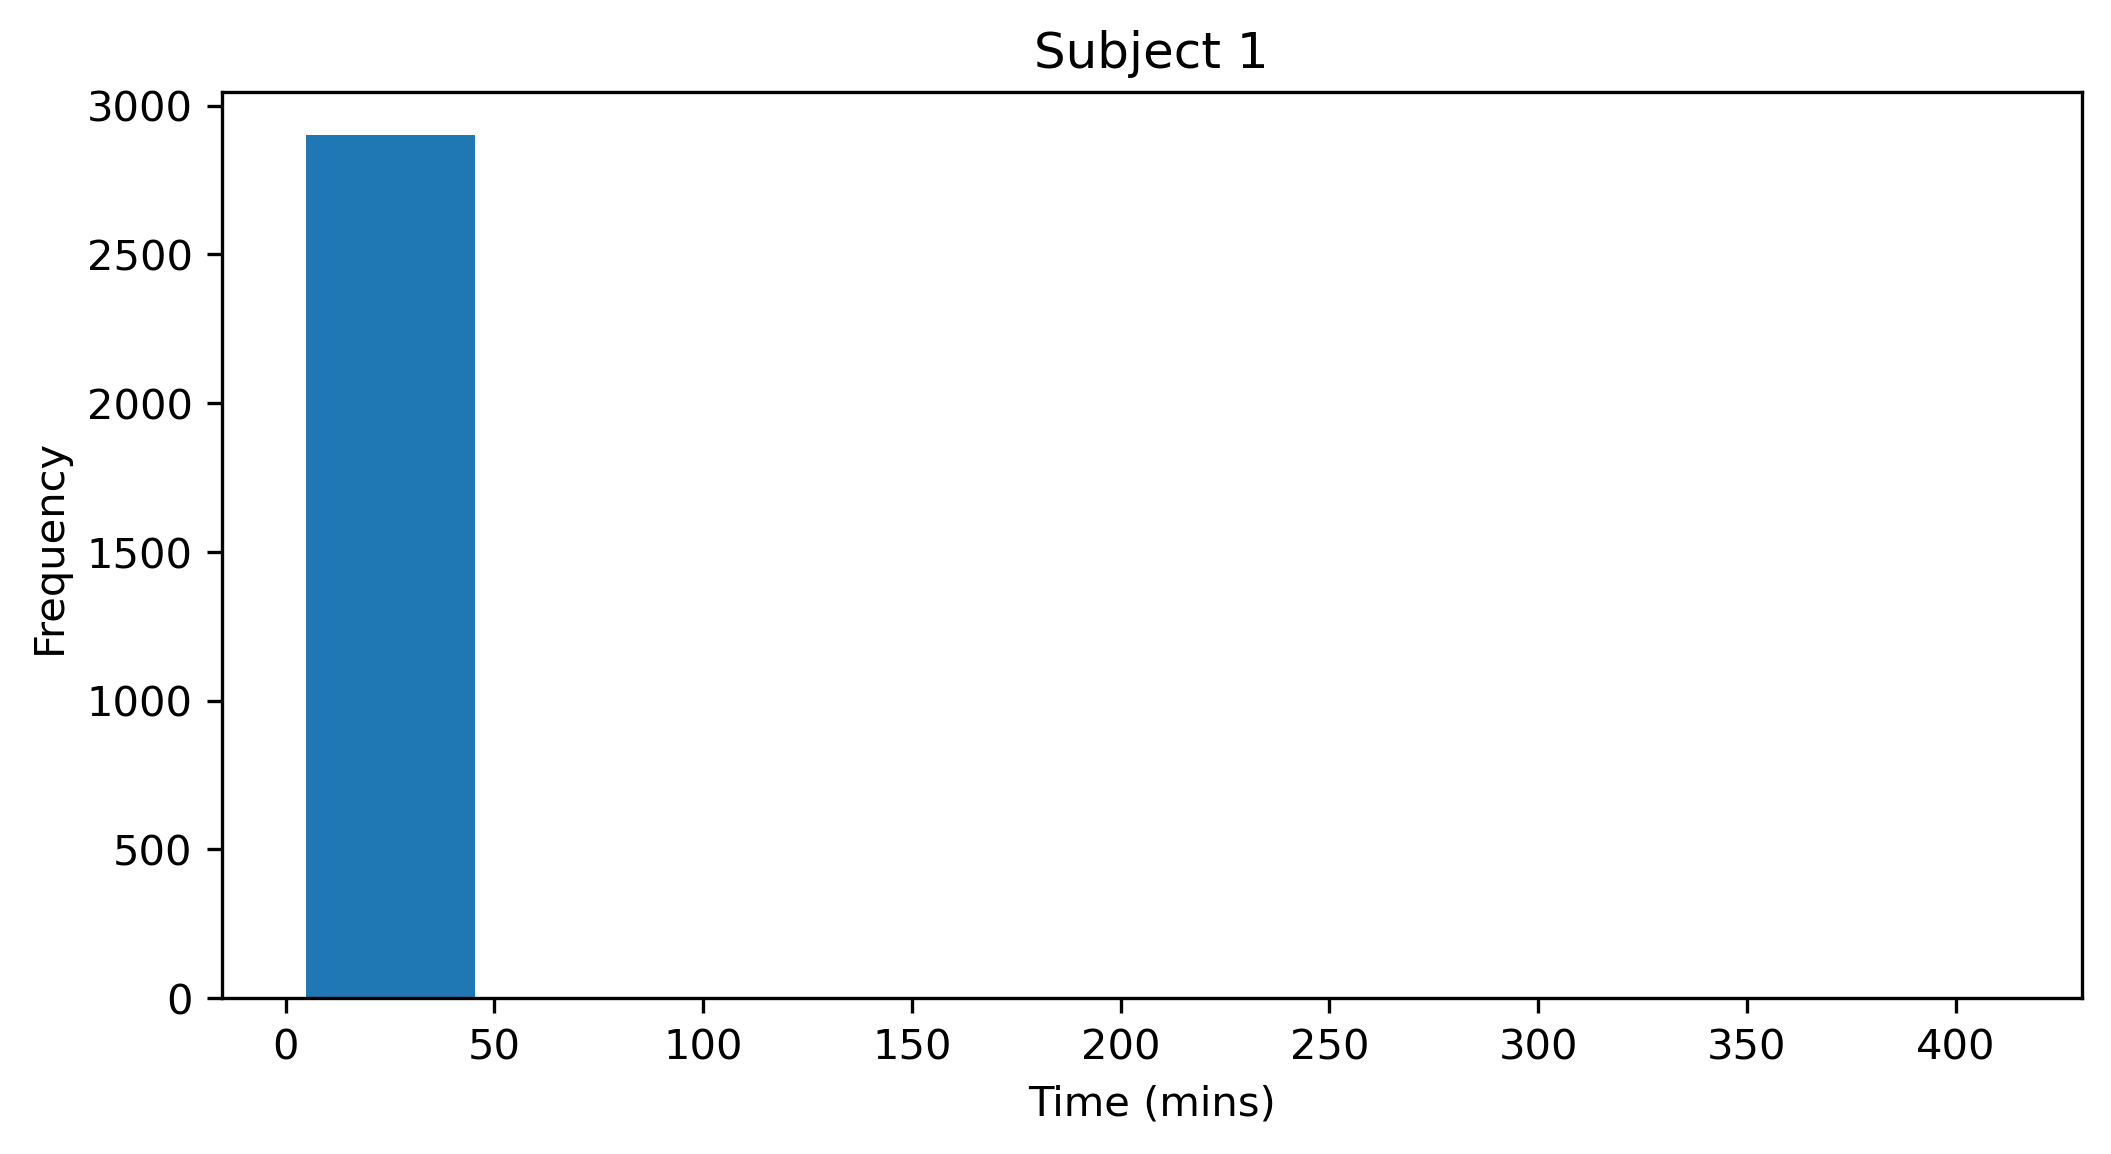

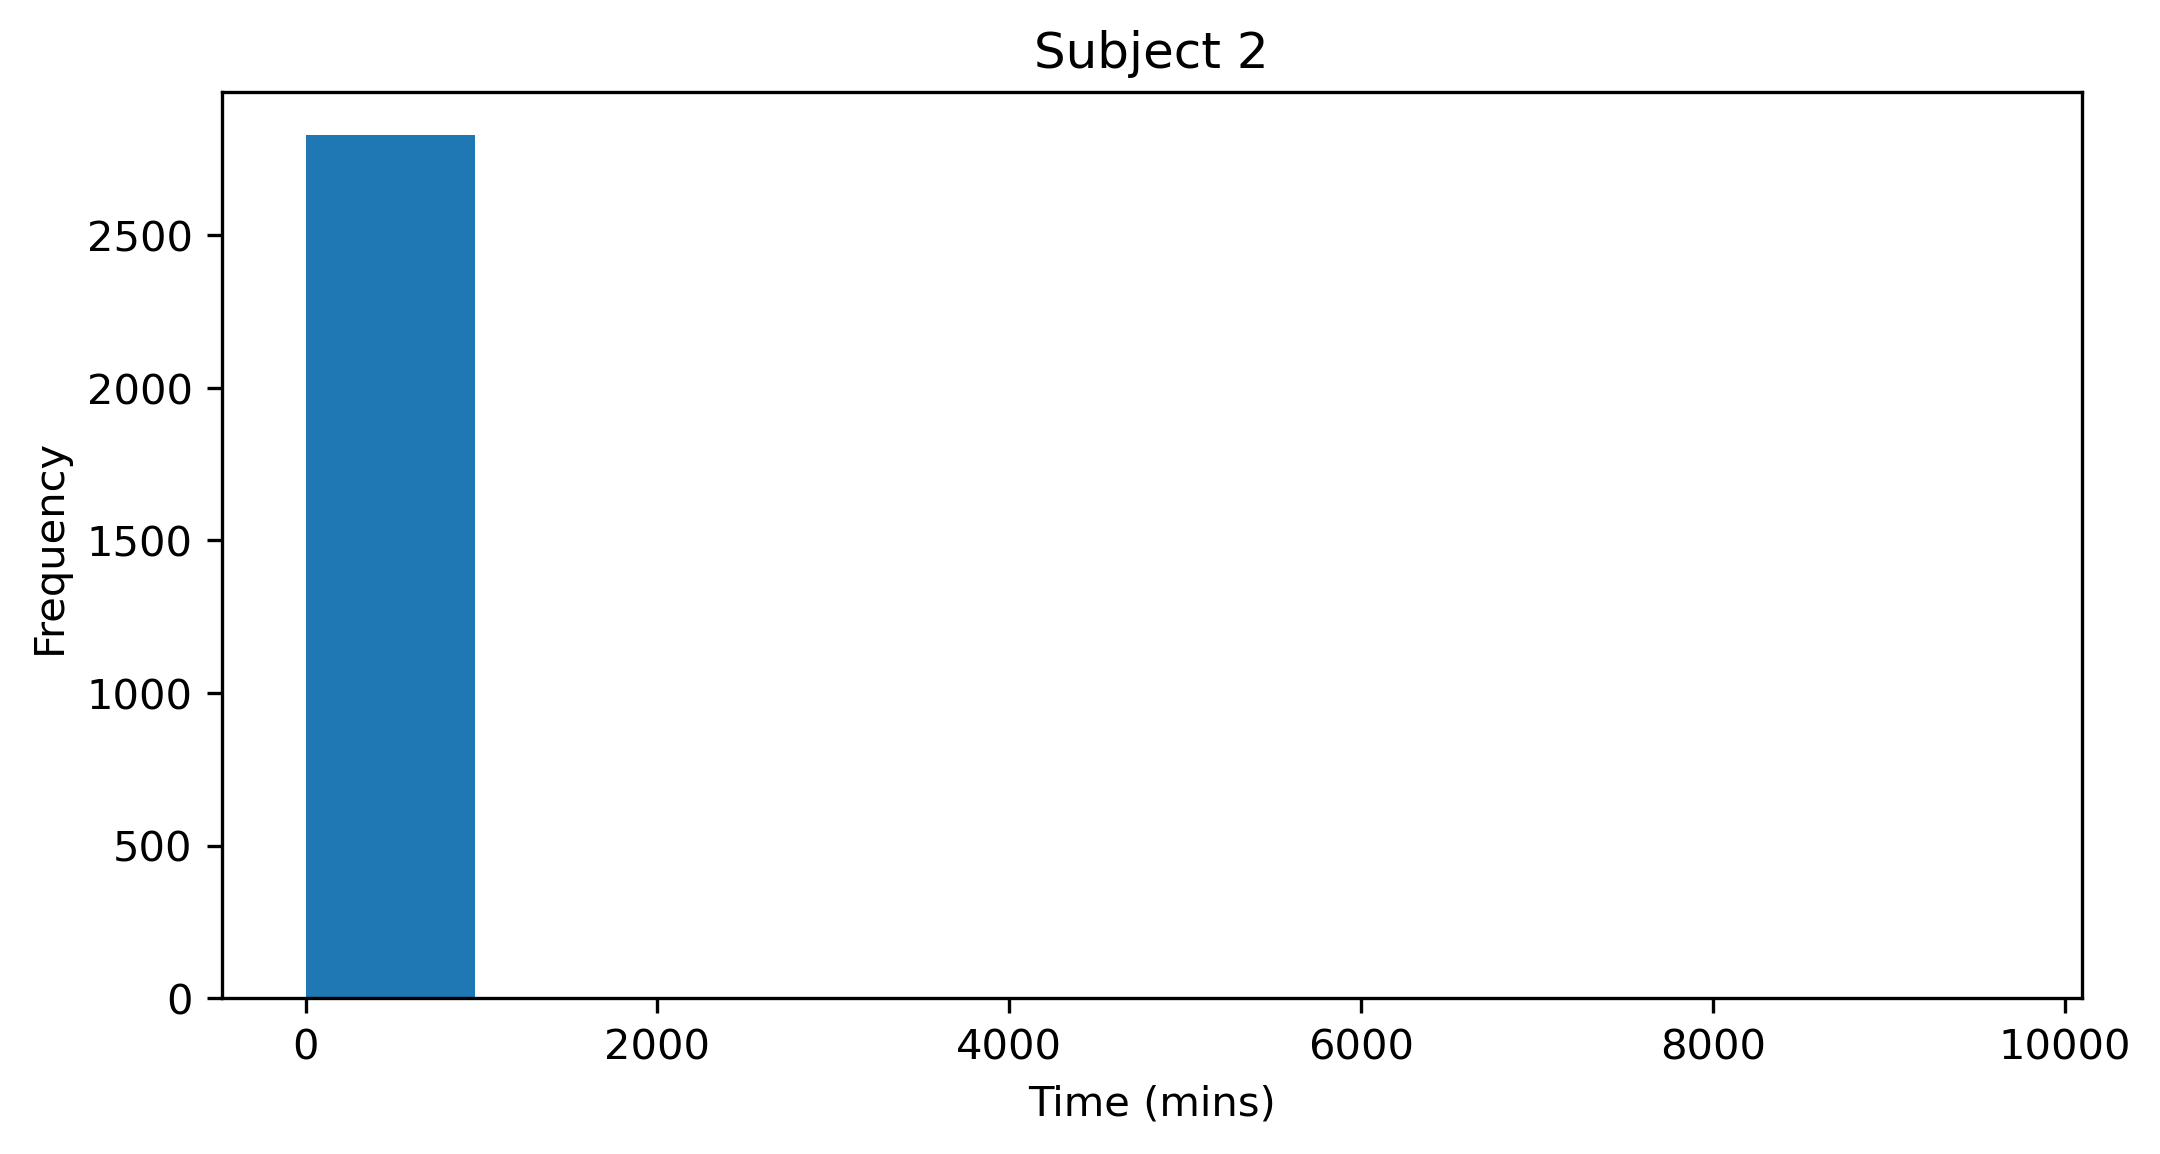

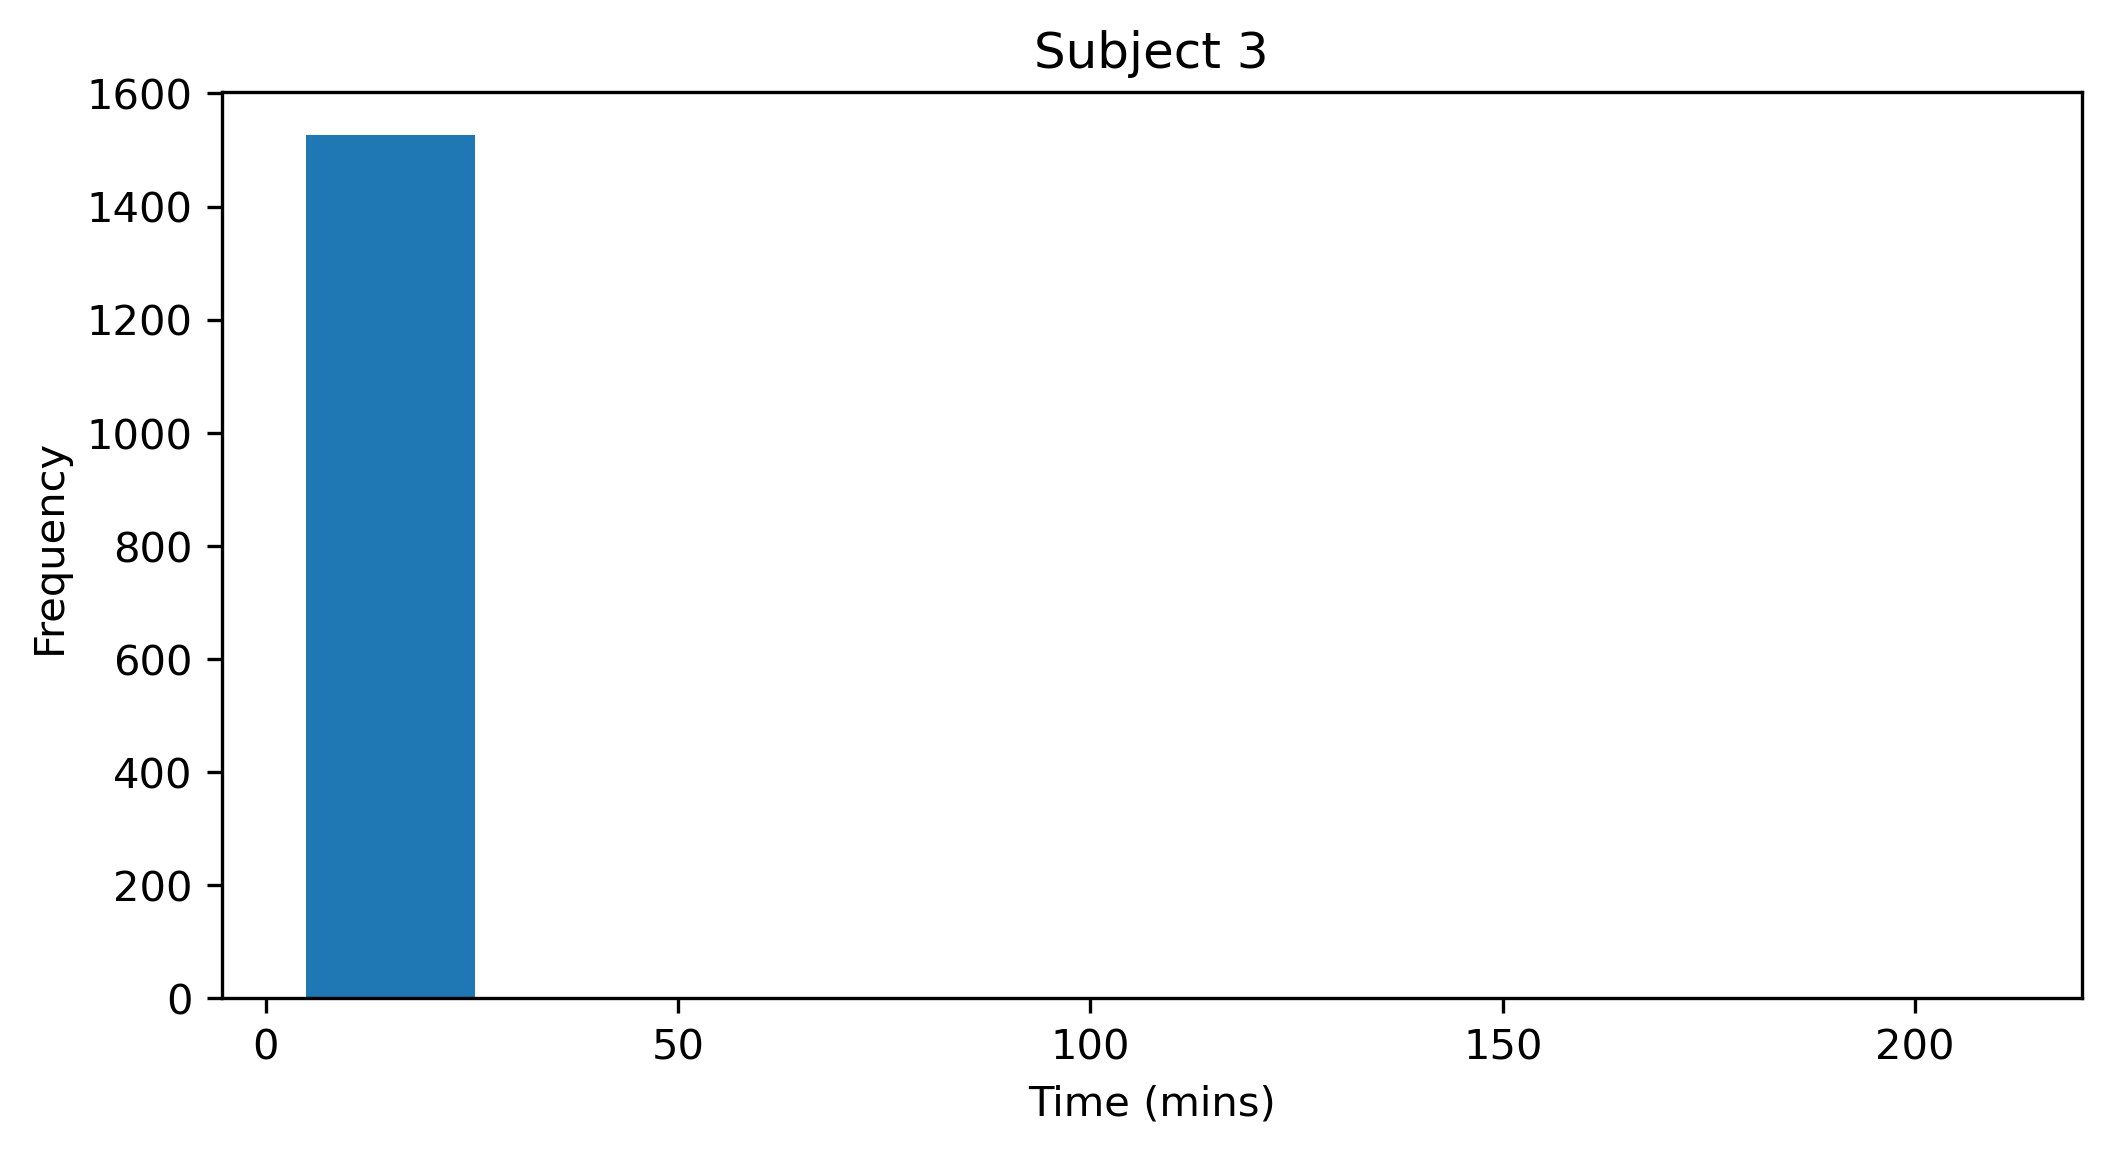

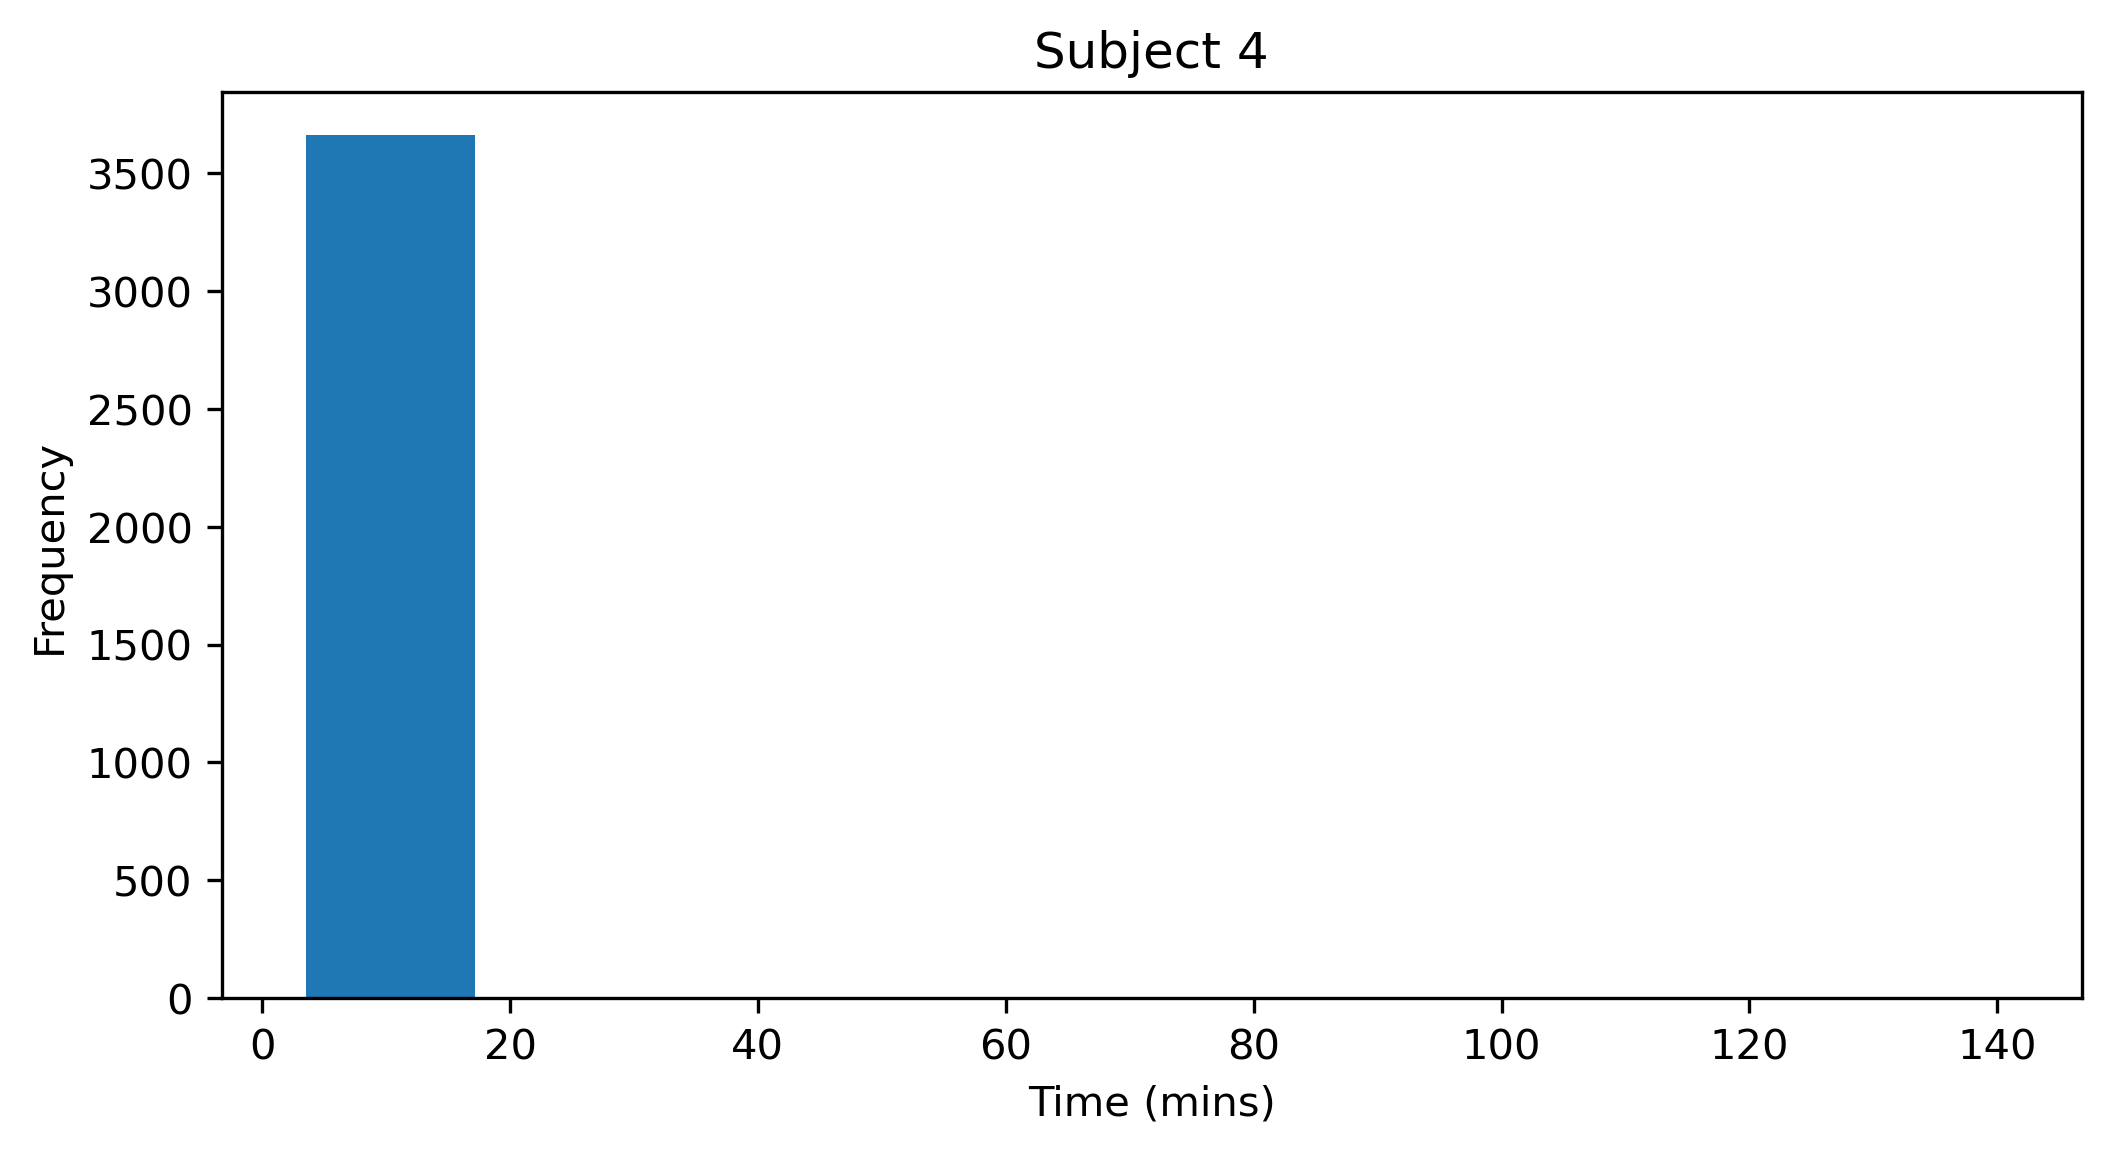

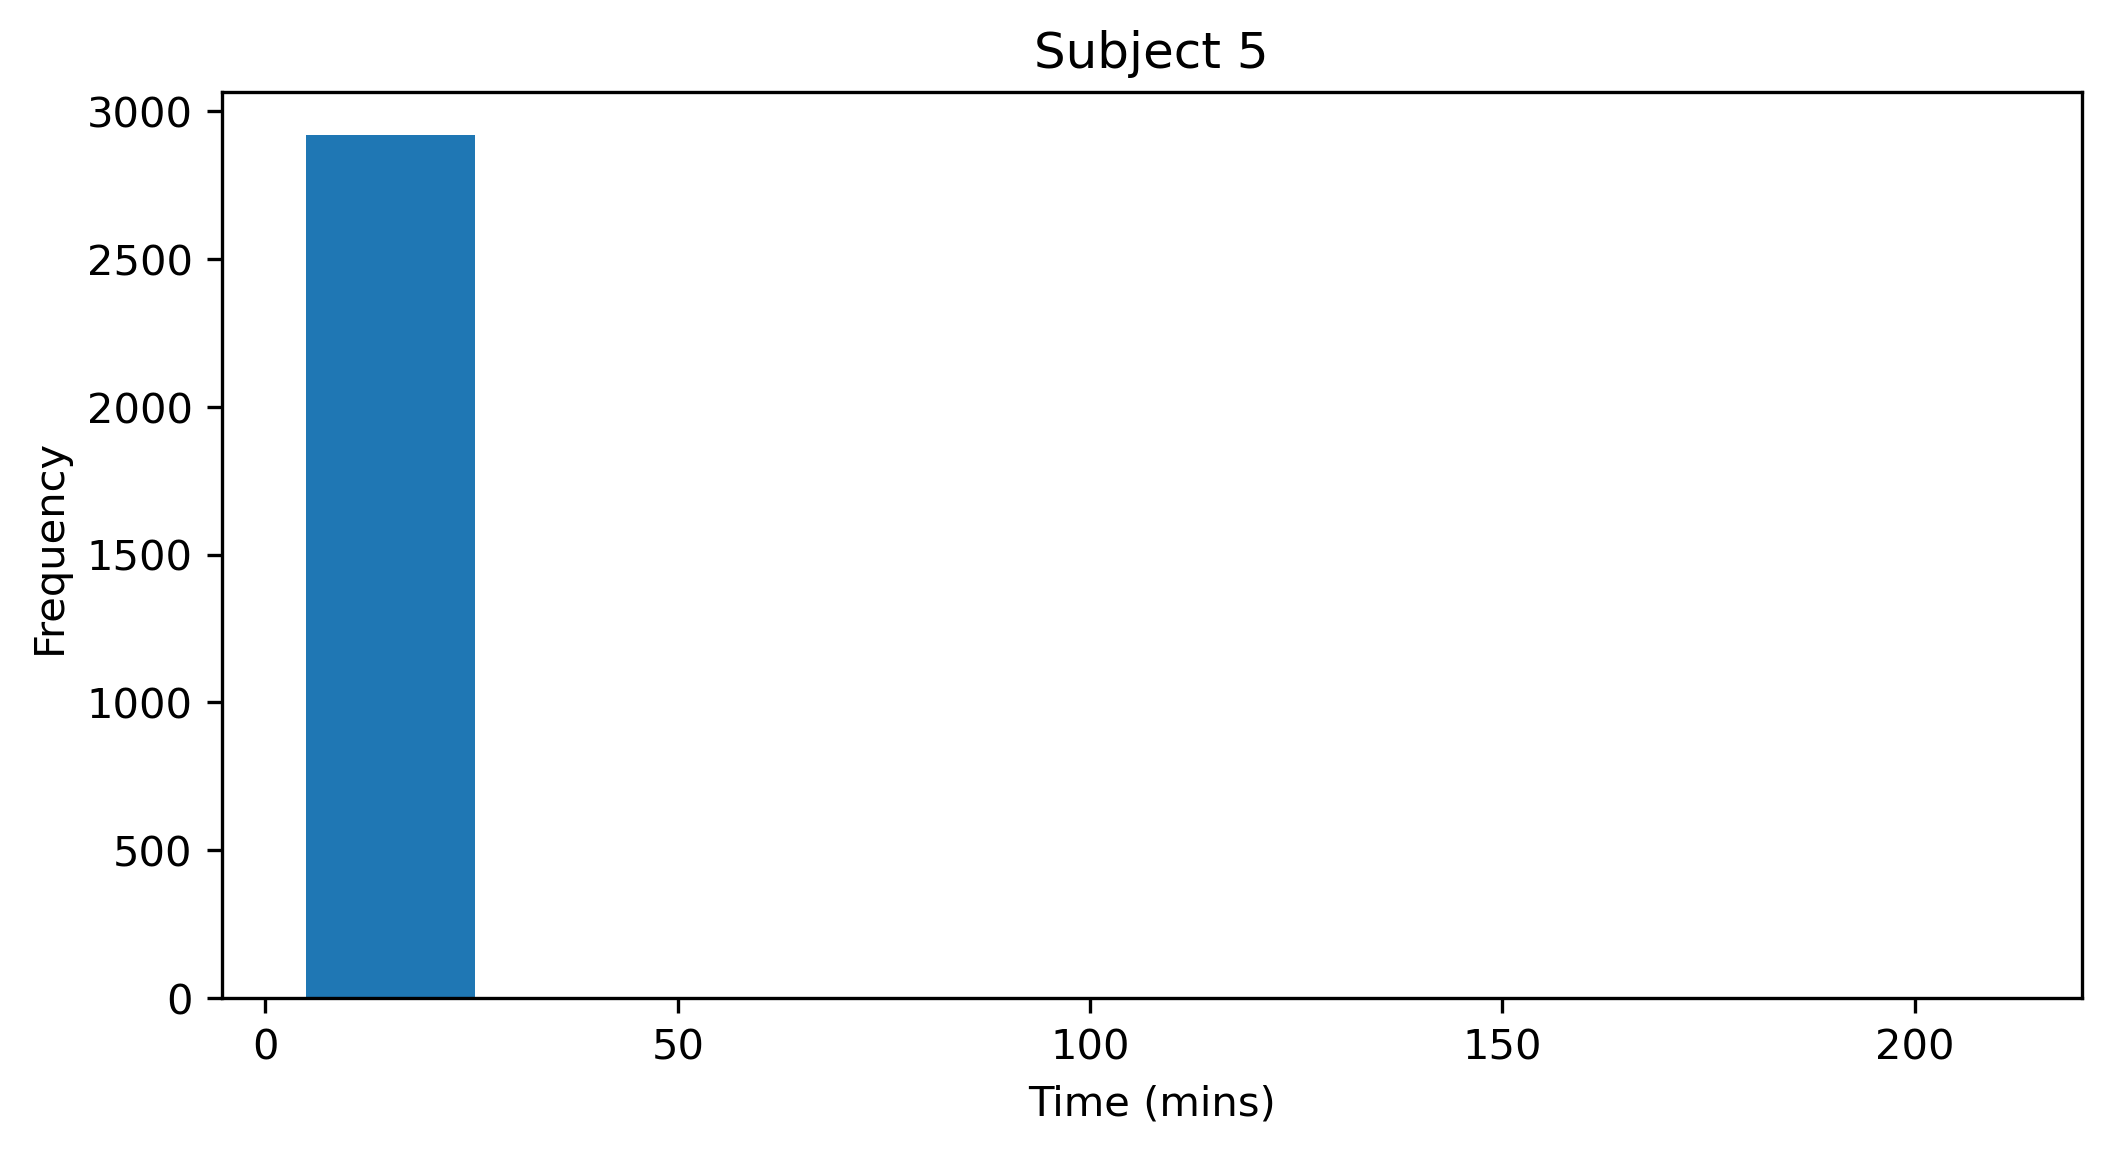

In [60]:
for subject in subjects:
    fig, ax = plt.subplots(figsize = (8,4), dpi = 300)
    ax.hist(subj_td[subject][0])
    plt.title(subject)
    plt.xlabel('Time (mins)')
    plt.ylabel('Frequency')
    plt.show()

In [119]:
subj_counts = {"Subject 1": [], "Subject 2": [], "Subject 3": [], "Subject 4": [], "Subject 5": []}

for subject in subjects:
    counts = {'>=0': 0, '>=10': 0, '>=15': 0, '>=20': 0, '>=25': 0, '>=30': 0, '>=35': 0, '>=40': 0, '>=45': 0, '>=50': 0}
    for time in subj_td[subject][0]:
        if time >= 0 and time <= 10:
            counts['>=0'] += 1
        elif time >= 10 and time <= 15:
            counts['>=10'] += 1
        elif time >= 15 and time <= 20:
            counts['>=15'] += 1
        elif time >= 20 and time <= 25:
            counts['>=20'] += 1
        elif time >= 25 and time <= 30:
            counts['>=25'] += 1
        elif time >= 30 and time <= 35:
            counts['>=30'] += 1
        elif time >= 35 and time <= 40:
            counts['>=35'] += 1
        elif time >= 40 and time <= 45:
            counts['>=40'] += 1
        elif time >= 45 and time <= 50:
            counts['>=45'] += 1
        elif time >= 50:
            counts['>=50'] += 1
    subj_counts[subject] = counts

In [120]:
for subject in subjects:
    subj_counts[subject]['>=0'] = subj_counts[subject]['>=10']

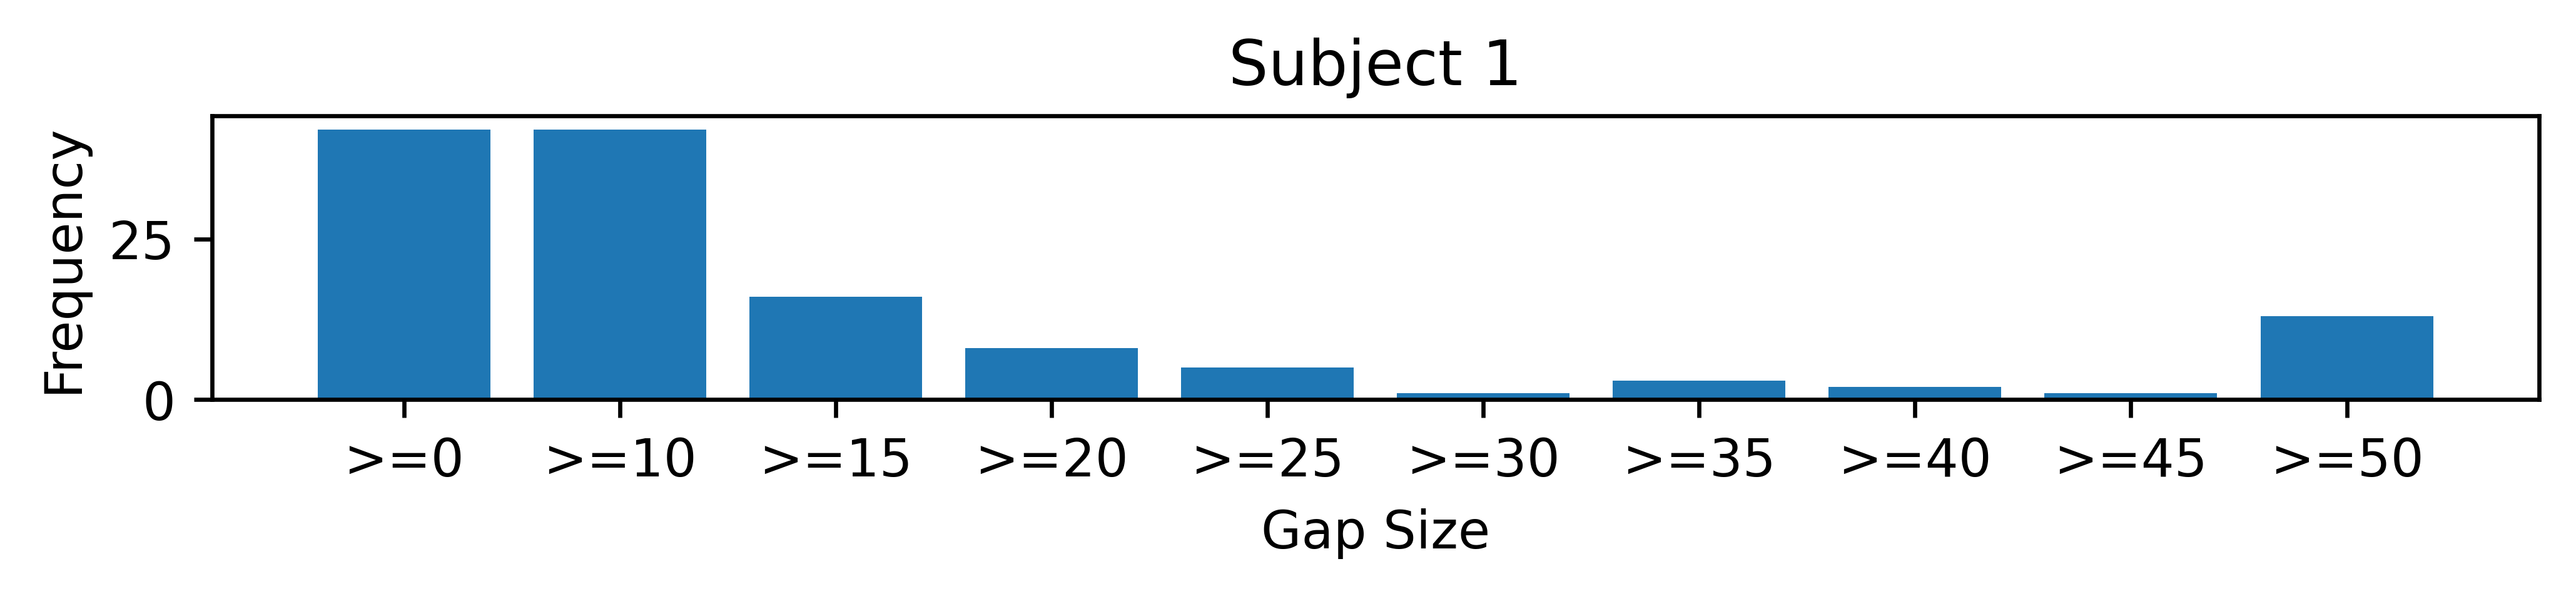

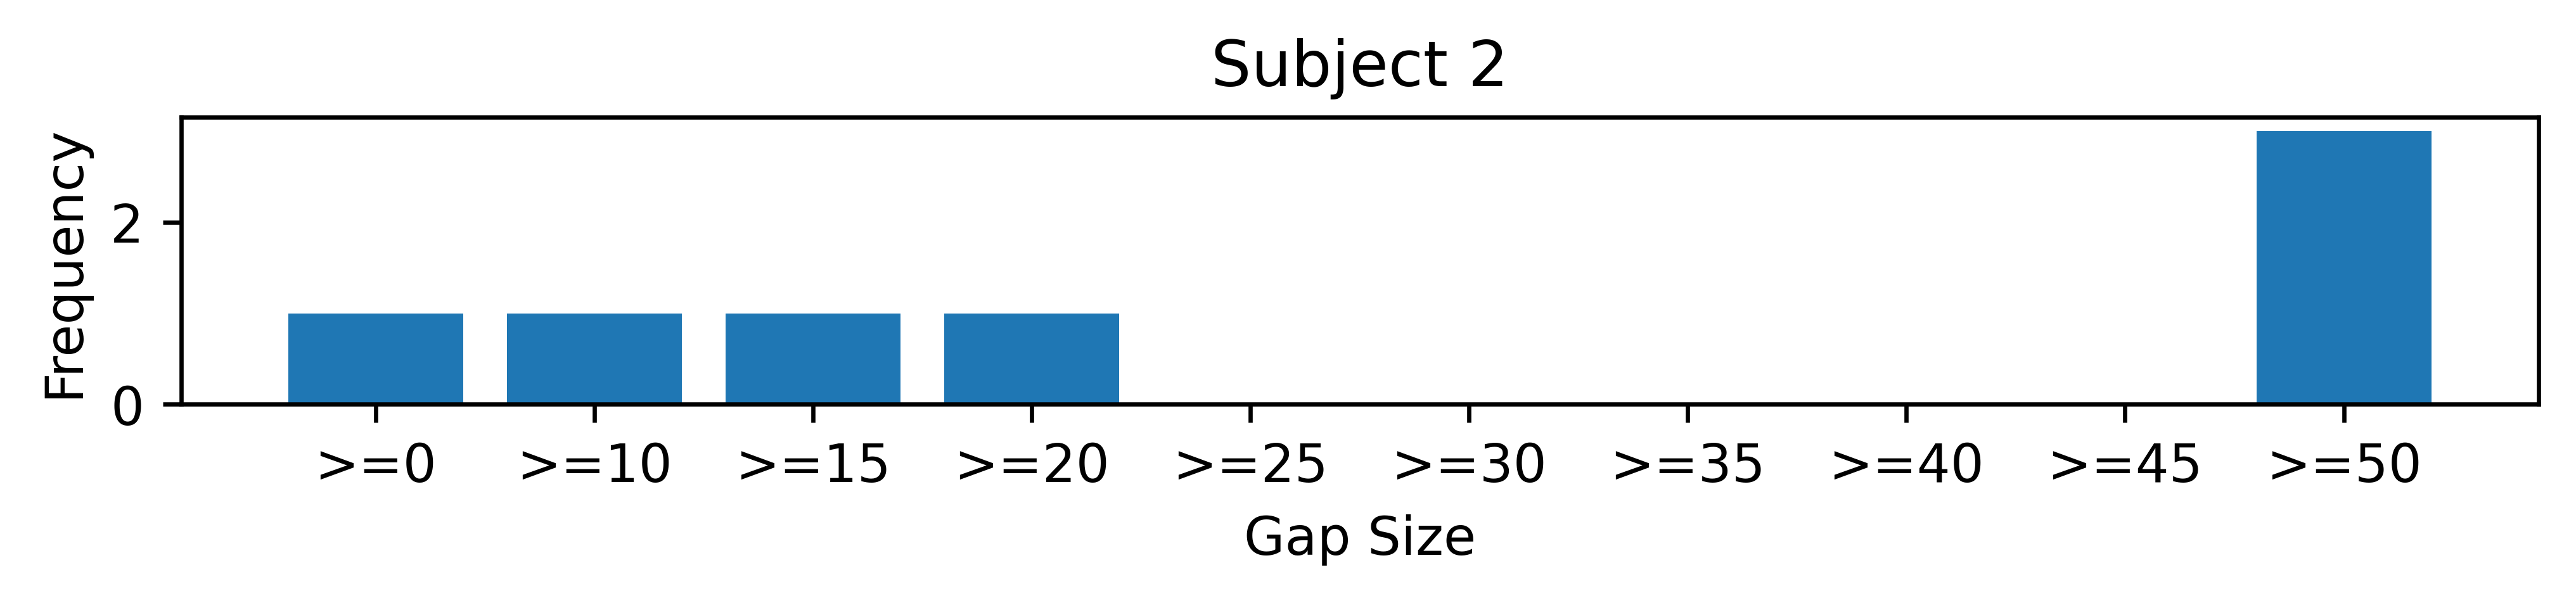

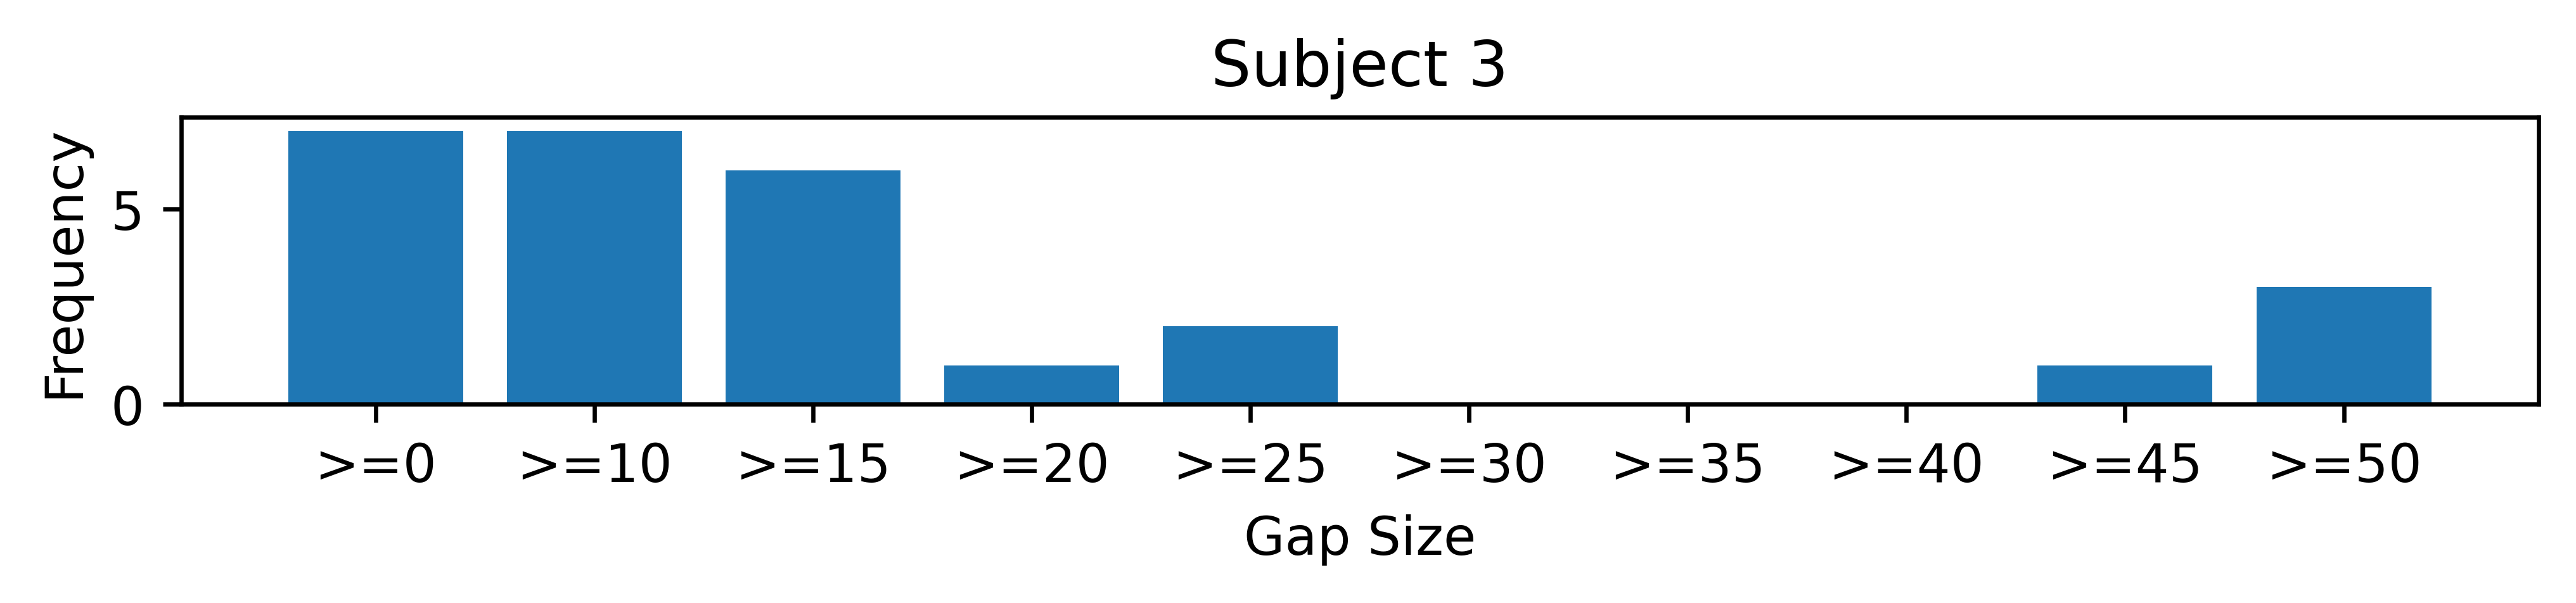

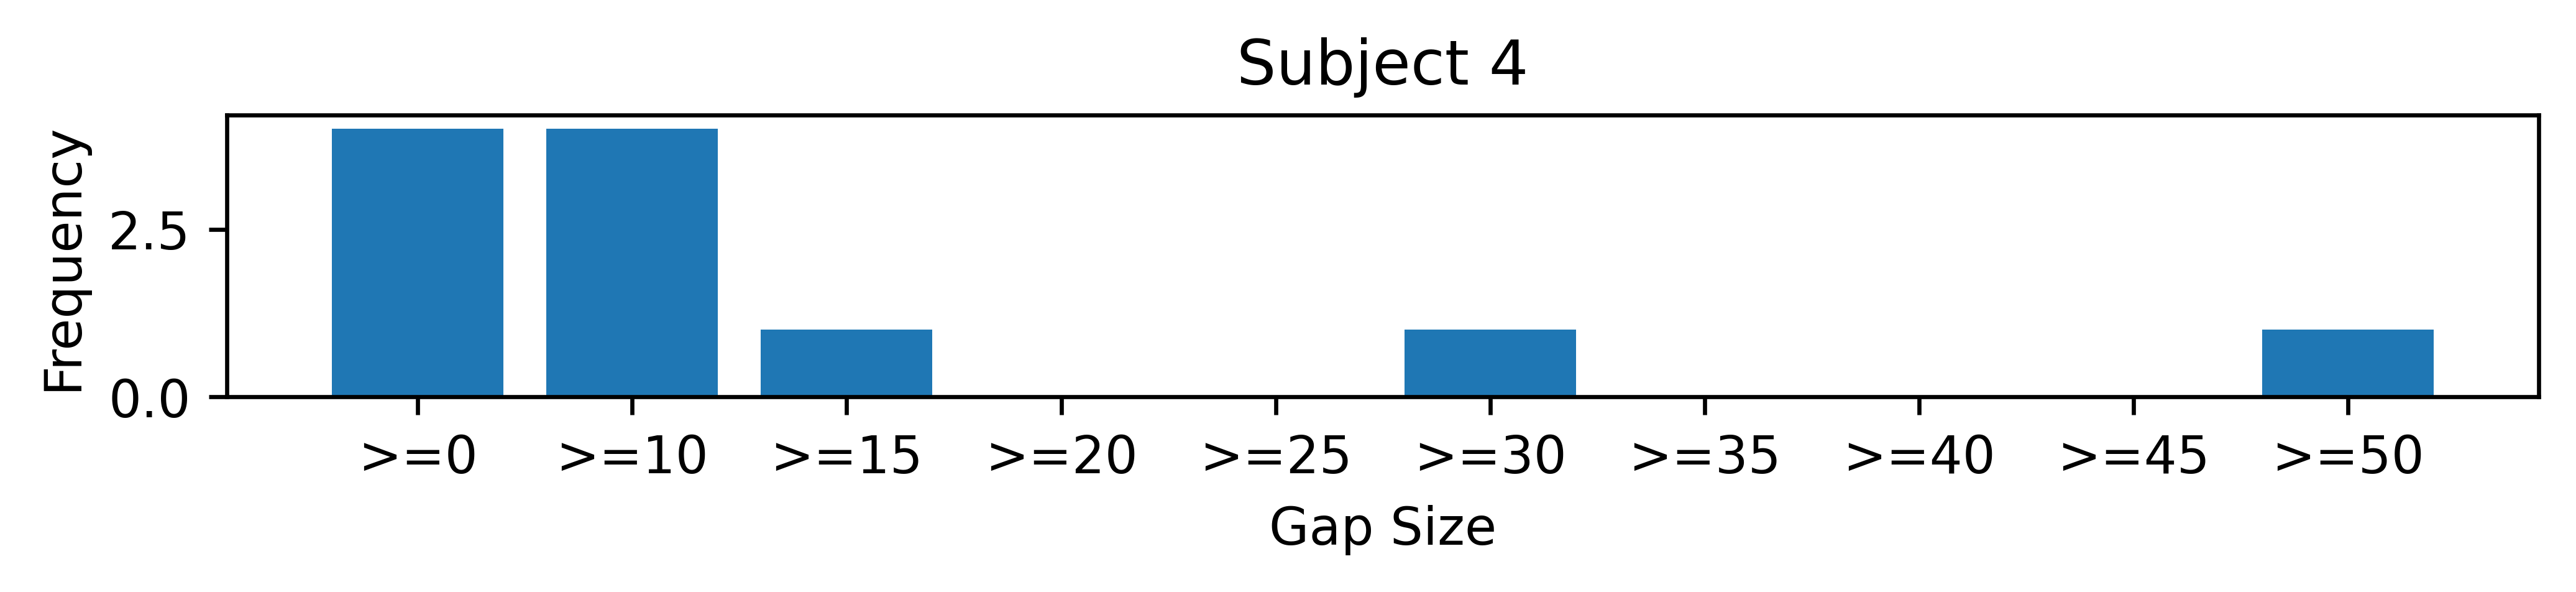

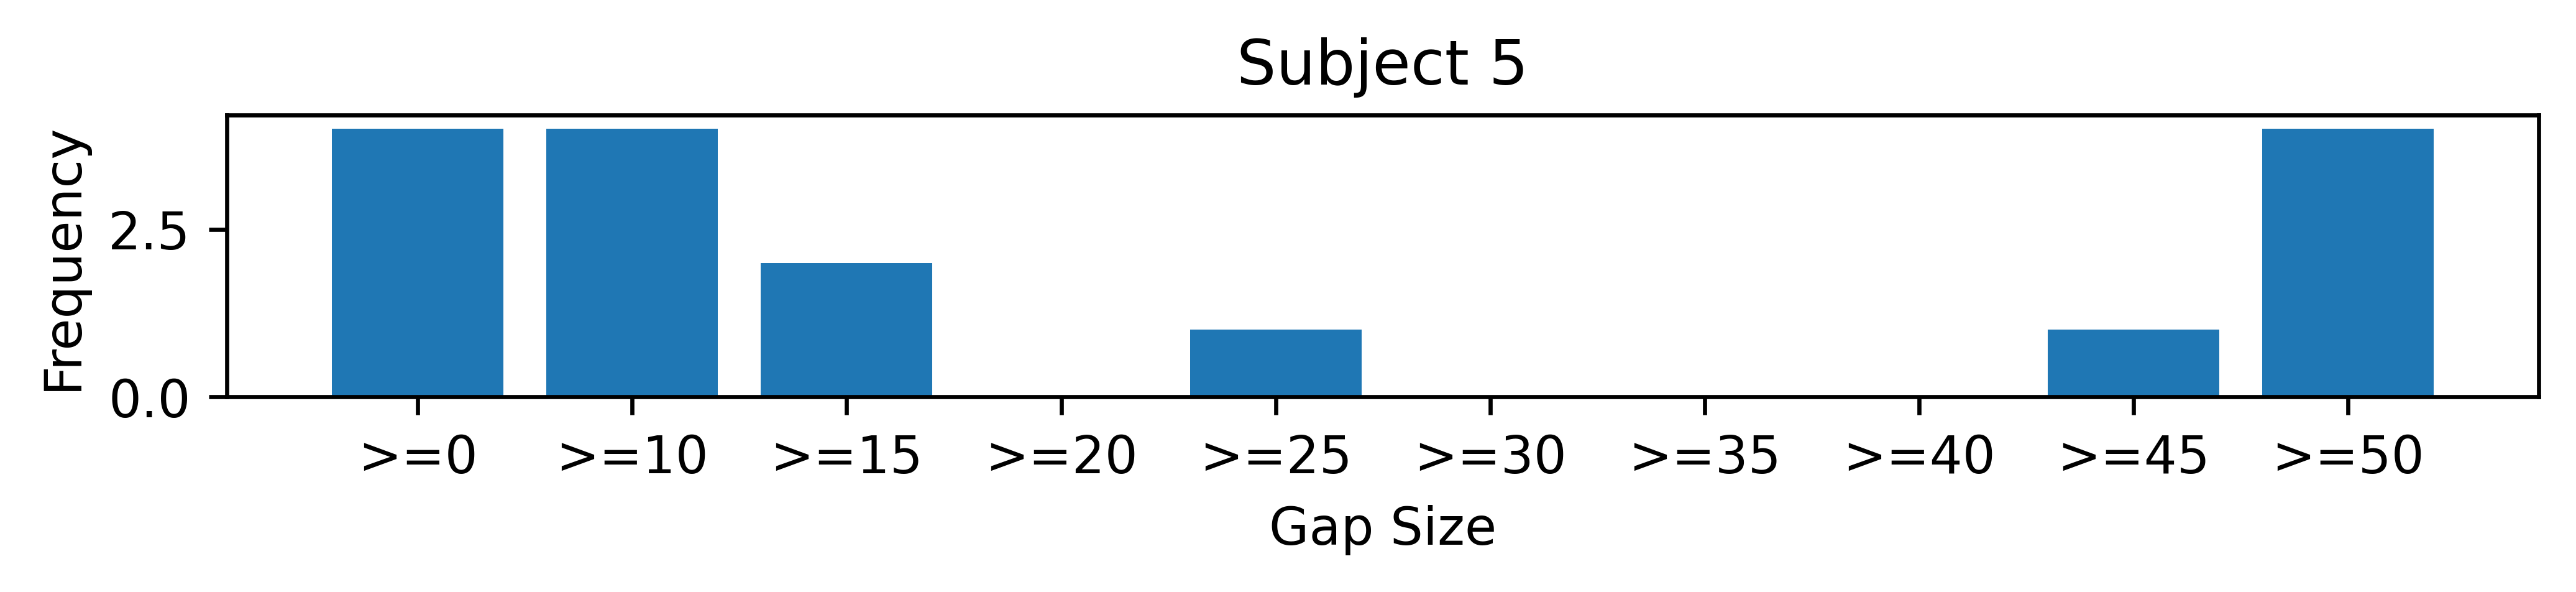

In [121]:
for subject in subjects:
    names = list(subj_counts[subject].keys())
    freq = list(subj_counts[subject].values())
    
    fig, ax = plt.subplots(figsize = (8, 1), dpi = 600)
    ax.bar(names, freq)
    plt.title(subject)
    plt.xlabel("Gap Size")
    plt.ylabel("Frequency")
    plt.show()